In [16]:
%%html
<style>
.dataframe td,.dataframe thead th { 
    note:'pandas表格属性';
    white-space: auto;
    text-align:left;
    border:1px solid;
    font-size:12px
}
.input_prompt{
    note:'隐藏cell左边的提示如 In[12]以便于截图';
#     display:none;
}
div.output_text {
    note:'输出内容的高度';
    max-height: 200px;
}
div.output_area img{
    note:'输出图片的宽度';
    max-width:100%
}
div.output_scroll{
    note:'禁用输出的阴影';
    box-shadow: none;
}
</style>
<h5>!!以上是作者为了排版而修改的排版效果，请注意是否需要使用!!</h5>

In [2]:
# 修改pandas默认的现实设置
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',10)  
pd.set_option('display.max_rows',20)  
#禁用科学计数法
np.set_printoptions(suppress=True,   precision=10,  threshold=2000,  linewidth=150)  
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 软投票简单示例

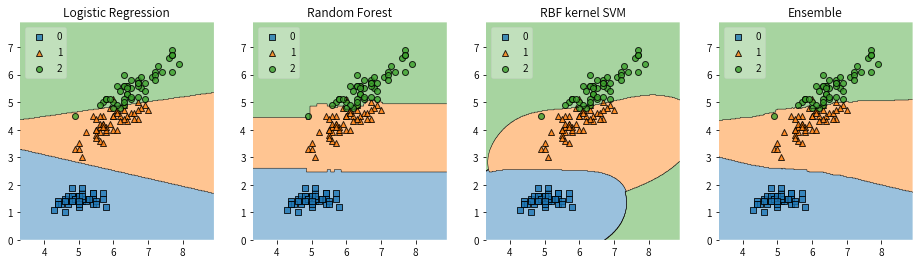

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##主要使用pip install mlxtend安装mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0, 
                          solver='lbfgs', multi_class='auto')
clf2 = RandomForestClassifier(random_state=0, n_estimators=100)
clf3 = SVC(random_state=0, probability=True, gamma='auto')
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3],
                              weights=[2, 1, 1],
                              voting='soft')

# Loading some example data
X, y = iris_data()
X = X[:, [0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(1, 4)
fig = plt.figure(figsize=(16, 4))

for clf, lab, grd in zip(
    [clf1, clf2, clf3, eclf],
    ['Logistic Regression', 'Random Forest', 
     'RBF kernel SVM', 'Ensemble'],
        itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[0, grd[0] * 2 + grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

# 导入包

In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

# 导入数据

In [14]:
#load_dataset
with open("./zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")

# 合并数据

In [15]:
#merge train_set and test_set
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)


# 删除相关特征

In [16]:
data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

# 数据最大最小归一化

In [17]:
# normalise numeric columns
cols_numeric=list(data_all.columns)
cols_numeric.remove("oringin")
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col!='target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax,axis=0)

# 画图：探查特征和标签相关信息

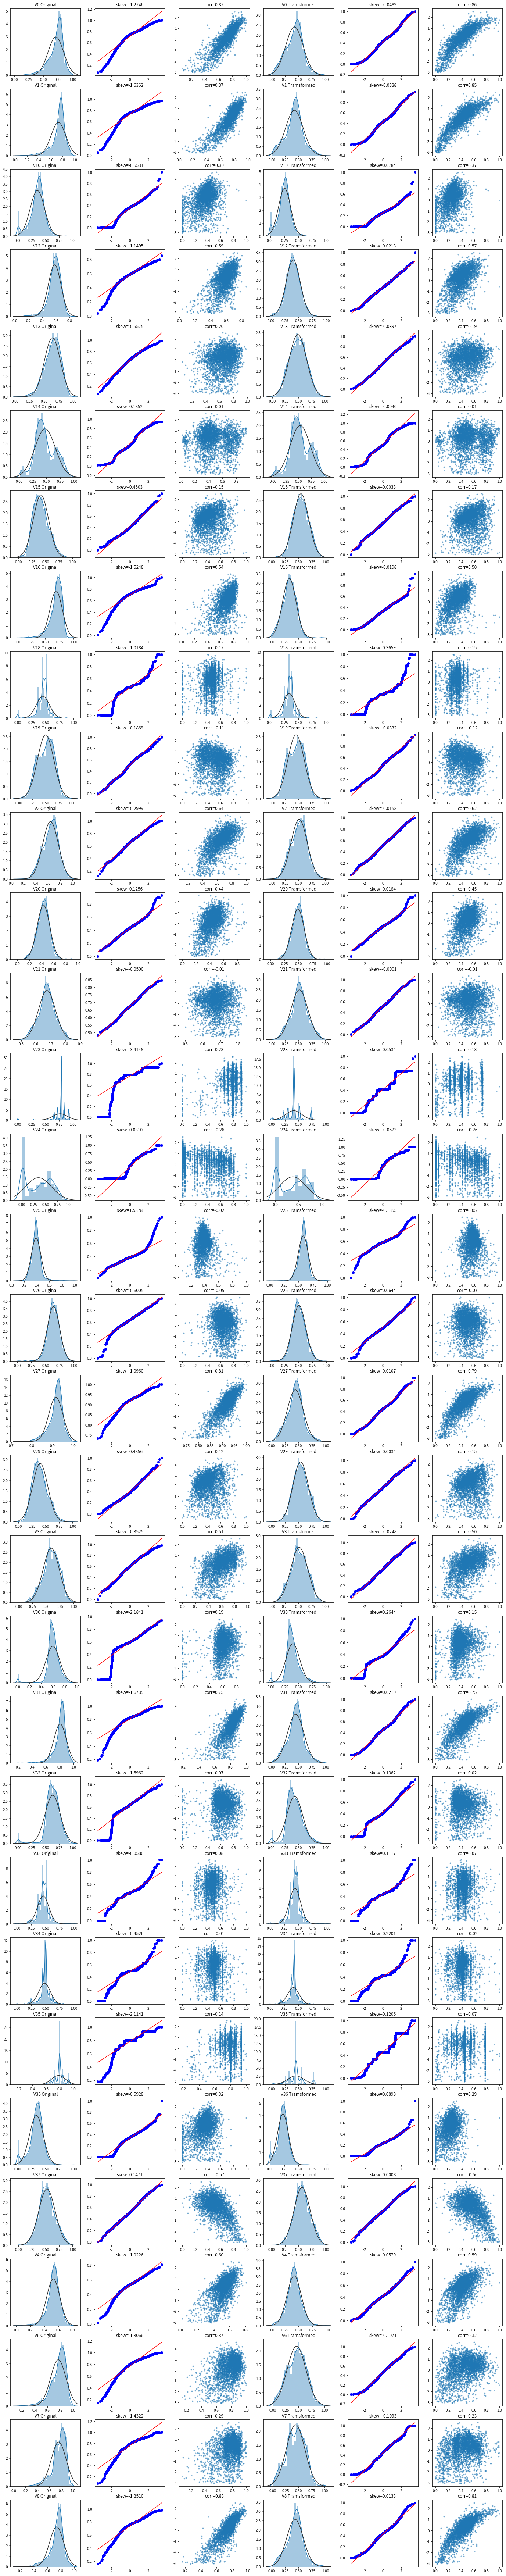

In [18]:
#Check effect of Box-Cox transforms on distributions of continuous variables

fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric:
    if var!='target':
        dat = data_all[[var, 'target']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

# 对特征进行Box-Cox变换，使其满足正态性

Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，是统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式，Box-Cox变换可以明显地改善数据的正态性、对称性和方差相等性，对许多实际数据都是行之有效的

In [19]:
cols_transform=data_all.columns[0:-2]
for col in cols_transform:   
    # transform column
    data_all.loc[:,col], _ = stats.boxcox(data_all.loc[:,col]+1)

#  标签数据统计转换后的数据，计算分位数画图展示（基于正态分布）

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


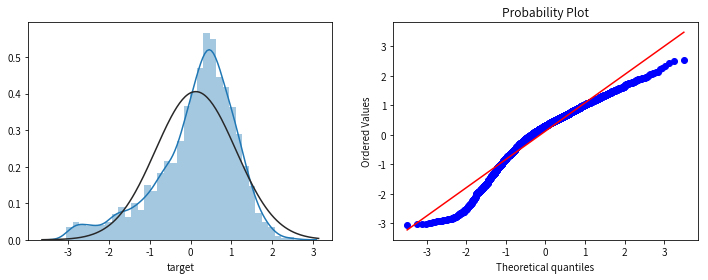

In [20]:
print(data_all.target.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_all.target.dropna(), plot=plt)

# 标签数据对数变换数据，使数据更符合正态，并画图展示

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


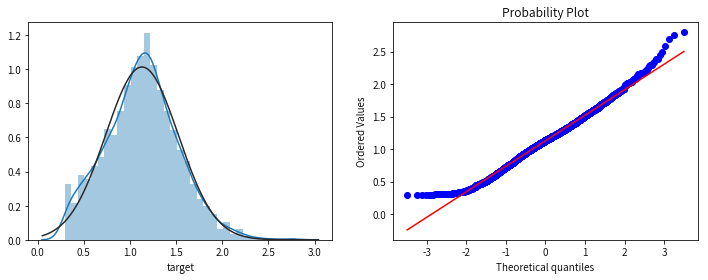

In [21]:
#Log Transform SalePrice to improve normality
sp = data_train.target
data_train.target1 =np.power(1.5,sp)
print(data_train.target1.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_train.target1.dropna(), plot=plt)

# 获取训练和测试数据

In [22]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"] == "train"]
    df_train["label"] = data_train.target1
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin", "target", "label"], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.3,
                                                          random_state=100)
    return X_train, X_valid, y_train, y_valid


# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"] == "test"].reset_index(drop=True)
    return df_test.drop(["oringin", "target"], axis=1)

# 评分函数

In [23]:
from sklearn.metrics import make_scorer
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)
def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mse_scorer = make_scorer(mse, greater_is_better=False)

# 获取异常数据，并画图

In [24]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.8794138470953522
rmse= 0.3451033881504985
mse= 0.11909634851295378
---------------------------------------
mean of residuals: -5.077031763278425e-16
std of residuals: 0.34518879921186085
---------------------------------------
23 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 776, 2625, 884, 2696, 2668, 1310, 1901, 2769, 2002, 2669, 1040]


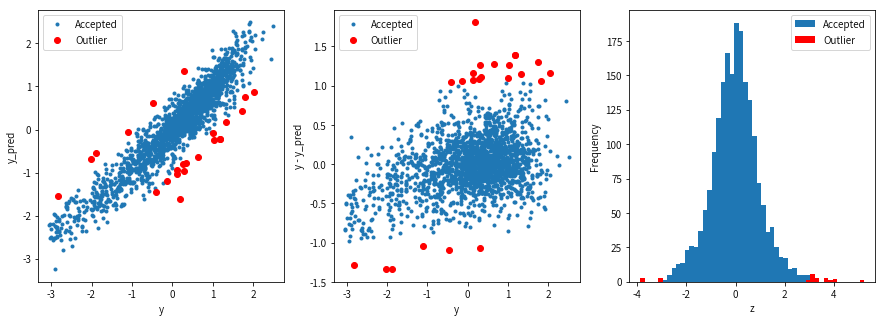

In [25]:
# get training data
from sklearn.linear_model import Ridge
X_train, X_valid,y_train,y_valid = get_training_data()
test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
#df_train = data_all[data_all["oringin"]=="train"]
#df_train["label"]=data_train.target1
#df_train=df_train.drop(outliers)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

# 使用删除异常的数据进行模型训练

In [26]:
def get_trainning_data_omitoutliers():
    y1=y_t.copy()
    X1=X_t.copy()
    return X1,y1

# 采用网格搜索训练模型

In [27]:
from sklearn.preprocessing import StandardScaler

def train_model(model, param_grid=[], X=[], y=[], splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y) == 0:
        X, y = get_trainning_data_omitoutliers()
        #poly_trans=PolynomialFeatures(degree=2)
        #X=poly_trans.fit_transform(X)
        #X=MinMaxScaler().fit_transform(X)

    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)

    # perform a grid search if param_grid given
    if len(param_grid) > 0:
        # setup grid search parameters
        gsearch = GridSearchCV(model,
                               param_grid,
                               cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1,
                               return_train_score=True)

        # search the grid
        gsearch.fit(X, y)

        # extract best model from the grid
        model = gsearch.best_estimator_
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx, 'mean_test_score'])
        cv_std = grid_results.loc[best_idx, 'std_test_score']

    # no grid search, just cross-val score for given model
    else:
        grid_results = []
        cv_results = cross_val_score(model,
                                     X,
                                     y,
                                     scoring="neg_mean_squared_error",
                                     cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)

    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean': cv_mean, 'std': cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)

    # print stats on model performance
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=', model.score(X, y))
    print('rmse=', rmse(y, y_pred))
    print('mse=', mse(y, y_pred))
    print('cross_val: mean=', cv_mean, ', std=', cv_std)

    # residual plots
    y_pred = pd.Series(y_pred, index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid) / std_resid
    n_outliers = sum(abs(z) > 3)

    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1, 3, 1)
    plt.plot(y, y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.title('corr = {:.3f}'.format(np.corrcoef(y, y_pred)[0][1]))
    ax_132 = plt.subplot(1, 3, 2)
    plt.plot(y, y - y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    plt.title('std resid = {:.3f}'.format(std_resid))

    ax_133 = plt.subplot(1, 3, 3)
    z.plot.hist(bins=50, ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [28]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])
# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

# 岭回归

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    1.9s finished


----------------------
Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.8963563382451663
rmse= 0.3189964920003429
mse= 0.10175876190852487
cross_val: mean= 0.10625486835794902 , std= 0.00708182213496992


Text(0,0.5,'score')

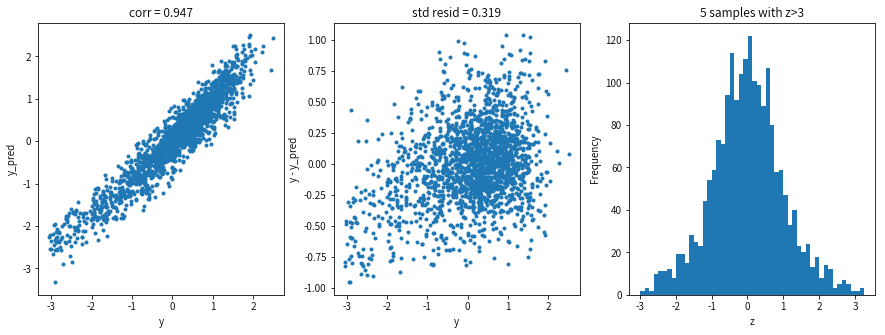

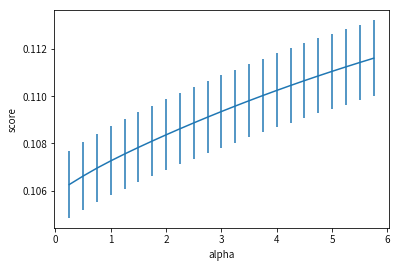

In [38]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(
    opt_models[model], param_grid=param_grid, 
    splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

# Lasso回归

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


----------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.8965376190808729
rmse= 0.3187173950531044
mse= 0.10158077790943673
cross_val: mean= 0.10610504464947475 , std= 0.006500758318074748


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    5.5s finished


Text(0,0.5,'score')

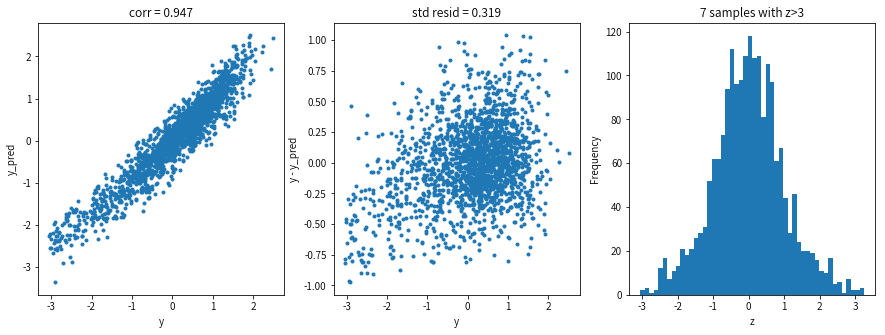

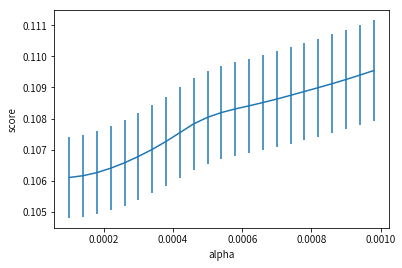

In [37]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4, 1e-3, 4e-5)
param_grid = {'alpha': alph_range}
opt_models[model], cv_score, grid_results = train_model(
    opt_models[model],param_grid=param_grid,
    splits=splits,repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(
    alph_range, abs(grid_results['mean_test_score']),
    abs(grid_results['std_test_score']) / np.sqrt(splits * repeats))
plt.xlabel('alpha')
plt.ylabel('score')

# ElasticNet 回归

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:    4.1s finished


----------------------
ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.8965268089368117
rmse= 0.31873404502255603
mse= 0.10159139145644094
cross_val: mean= 0.10600161516910325 , std= 0.009843376051613794


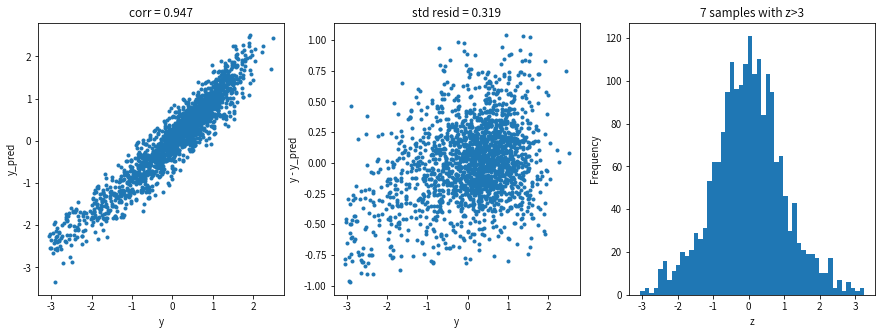

In [31]:
model = 'ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {
    'alpha': np.arange(1e-4, 1e-3, 1e-4),
    'l1_ratio': np.arange(0.1, 1.0, 0.1),
    'max_iter': [100000]
}

opt_models[model], cv_score, grid_results = train_model(
    opt_models[model],param_grid=param_grid,
    splits=splits,repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

# SVR回归

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   31.9s finished


----------------------
LinearSVR(C=0.7000000000000001, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
----------------------
score= -0.6086622622353797
rmse= 1.2567444323566297
mse= 1.5794065682593896
cross_val: mean= 1.2495437800119789 , std= 1.4709648845816063


Text(0,0.5,'score')

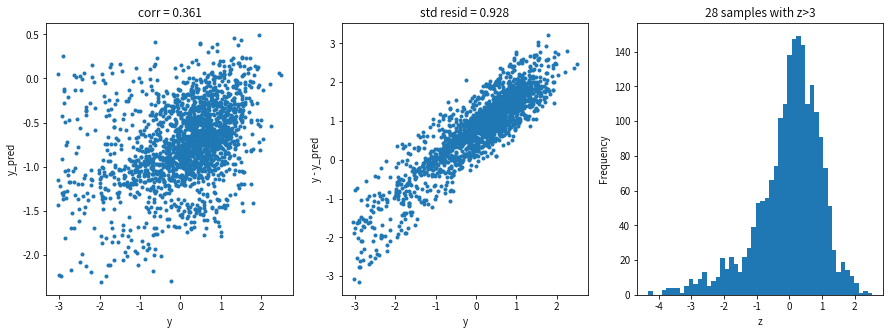

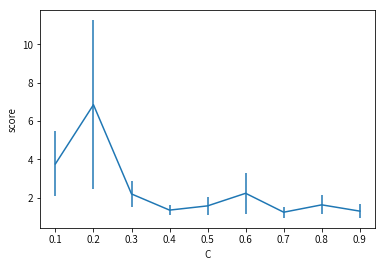

In [36]:
model = 'LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1, 1.0, 0.1)
param_grid = {'C': crange, 'max_iter': [1000]}

opt_models[model], cv_score, grid_results = train_model(
    opt_models[model],param_grid=param_grid,
    splits=splits,repeats=repeats)
cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(
    crange, 
    abs(grid_results['mean_test_score']),
    abs(grid_results['std_test_score']) / np.sqrt(splits * repeats))
plt.xlabel('C')
plt.ylabel('score')

# K最近邻

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')
----------------------
score= 0.7188007679386812
rmse= 0.5254381453364181
mse= 0.27608524457457456
cross_val: mean= 0.3414300083933934 , std= 0.03628248303958957


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


Text(0,0.5,'score')

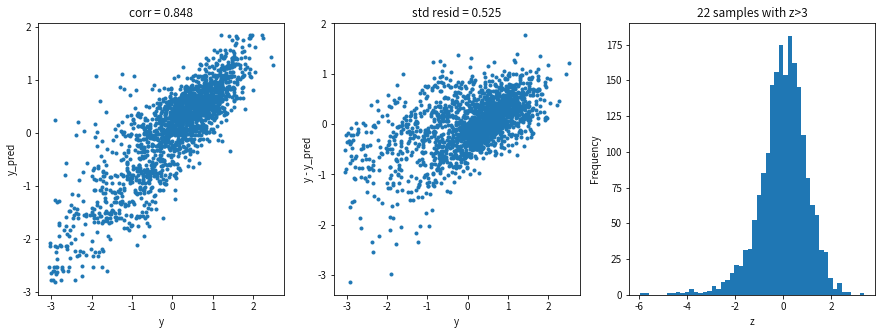

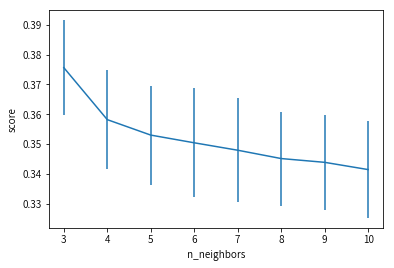

In [35]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors': np.arange(3, 11, 1)}

opt_models[model], cv_score, grid_results = train_model(
    opt_models[model],
    param_grid=param_grid,
    splits=splits,
    repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(
    np.arange(3, 11, 1), 
    abs(grid_results['mean_test_score']),
    abs(grid_results['std_test_score']) / np.sqrt(splits * 1))
plt.xlabel('n_neighbors')
plt.ylabel('score')

# GBDT 模型

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   58.7s finished


----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
score= 0.9680472852455987
rmse= 0.1771203306213963
mse= 0.03137161151943271
cross_val: mean= 0.09780879654074782 , std= 0.00416106697022724


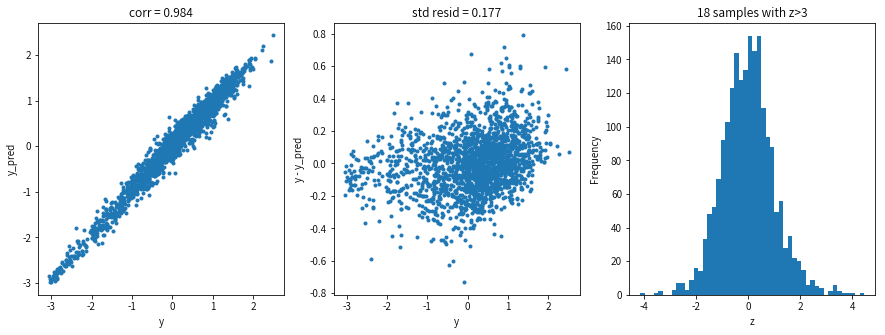

In [34]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [150, 250, 350],
    'max_depth': [1, 2, 3],
    'min_samples_split': [5, 6, 7]
}

opt_models[model], cv_score, grid_results = train_model(
    opt_models[model],
    param_grid=param_grid,
    splits=splits,
    repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

# XGB模型

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   56.7s finished


----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
----------------------
score= 0.9611848629687763
rmse= 0.1952158584412719
mse= 0.038109231386962795
cross_val: mean= 0.0962918558804569 , std= 0.004789249313980228


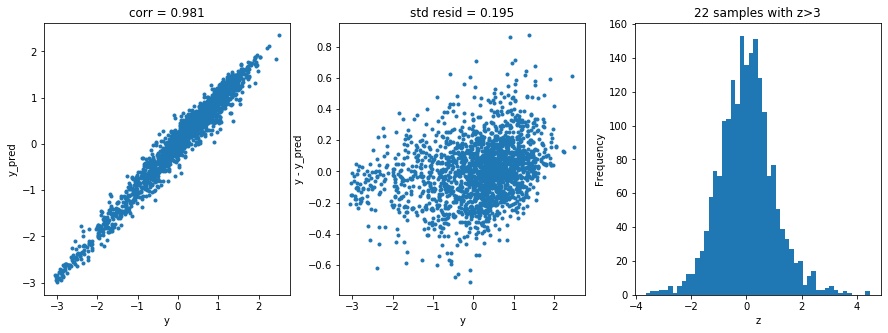

In [36]:
model = 'XGB'
#opt_models[model] = XGBRegressor()
opt_models[model] = XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [1, 2, 3],
}

opt_models[model], cv_score, grid_results = train_model(
    opt_models[model],
    param_grid=param_grid,
    splits=splits,
    repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

# 随机森林模型

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  5.7min finished


----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=16, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
score= 0.9857512512429285
rmse= 0.11827770725537559
mse= 0.013989616033588321
cross_val: mean= 0.10260814030321982 , std= 0.010072660612822415


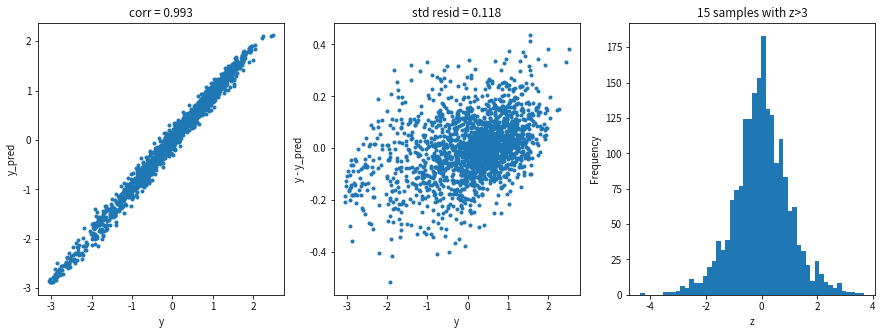

In [39]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': [8, 12, 16, 20, 24],
    'min_samples_split': [2, 4, 6]
}

opt_models[model], cv_score, grid_results = train_model(
    opt_models[model],
    param_grid=param_grid,
    splits=5,
    repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

# 模型预测--多模型Bagging

In [40]:
def model_predict(test_data,test_y=[],stack=False):
    #poly_trans=PolynomialFeatures(degree=2)
    #test_data1=poly_trans.fit_transform(test_data)
    #test_data=MinMaxScaler().fit_transform(test_data)
    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model!="LinearSVR" and model!="KNeighbors":
            y_predict=opt_models[model].predict(test_data)
            y_predict_total+=y_predict
            i+=1
        if len(test_y)>0:
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,3)
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        return y_predict_mean

In [41]:
model_predict(X_valid,y_valid)

Ridge_mse: 0.13767187912956574
Lasso_mse: 0.13786131278622565
ElasticNet_mse: 0.137826957890393
LinearSVR_mse: 0.137826957890393
KNeighbors_mse: 0.137826957890393
GradientBoosting_mse: 0.13410427743376832
RandomForest_mse: 0.14081583252288532
mean_mse: 0.12710621337946942


## 模型融合Stacking

### 模型融合stacking简单示例

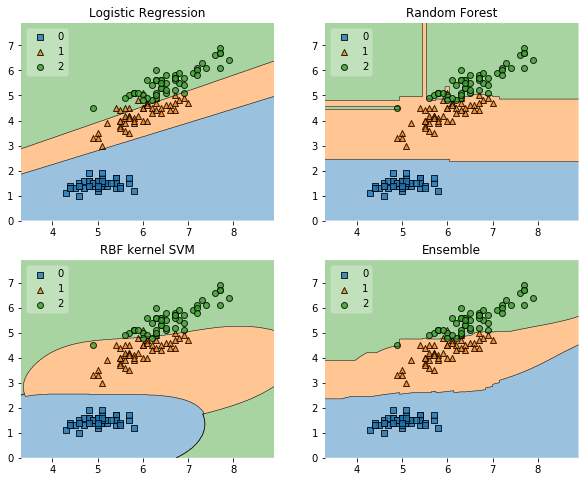

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##主要使用pip install mlxtend安装mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

### 工业蒸汽多模型融合stacking

In [7]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from scipy import sparse
import xgboost
import lightgbm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def stacking_reg(clf, train_x, train_y, test_x, clf_name, kf,
                 label_split=None):
    train = np.zeros((train_x.shape[0], 1))
    test = np.zeros((test_x.shape[0], 1))
    test_pre = np.empty((folds, test_x.shape[0], 1))
    cv_scores = []
    for i, (train_index,
            test_index) in enumerate(kf.split(train_x, label_split)):
        tr_x = train_x[train_index]
        tr_y = train_y[train_index]
        te_x = train_x[test_index]
        te_y = train_y[test_index]
        if clf_name in ["rf", "ada", "gb", "et", "lr", "lsvc", "knn"]:
            clf.fit(tr_x, tr_y)
            pre = clf.predict(te_x).reshape(-1, 1)
            train[test_index] = pre
            test_pre[i, :] = clf.predict(test_x).reshape(-1, 1)
            cv_scores.append(mean_squared_error(te_y, pre))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x, label=te_y, missing=-1)
            params = {
                'booster': 'gbtree',
                'eval_metric': 'rmse',
                'gamma': 1,
                'min_child_weight': 1.5,
                'max_depth': 5,
                'lambda': 10,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'colsample_bylevel': 0.7,
                'eta': 0.03,
                'tree_method': 'exact',
                'seed': 2017,
                'nthread': 12
            }
            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'), (test_matrix, 'eval')]
            if test_matrix:
                model = clf.train(
                    params,
                    train_matrix,
                    num_boost_round=num_round,
                    evals=watchlist,
                    early_stopping_rounds=early_stopping_rounds)
                pre = model.predict(
                    test_matrix,
                    ntree_limit=model.best_ntree_limit).reshape(-1, 1)
                train[test_index] = pre
                test_pre[i, :] = model.predict(
                    z, ntree_limit=model.best_ntree_limit).reshape(-1, 1)
                cv_scores.append(mean_squared_error(te_y, pre))

        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression_l2',
                'metric': 'mse',
                'min_child_weight': 1.5,
                'num_leaves': 2**5,
                'lambda_l2': 10,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'colsample_bylevel': 0.7,
                'learning_rate': 0.03,
                'tree_method': 'exact',
                'seed': 2017,
                'nthread': 12,
                'silent': True,
            }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(
                    params,
                    train_matrix,
                    num_round,
                    valid_sets=test_matrix,
                    early_stopping_rounds=early_stopping_rounds)
                pre = model.predict(
                    te_x, 
                    num_iteration=model.best_iteration).reshape(-1, 1)
                train[test_index] = pre
                test_pre[i, :] = model.predict(
                    test_x, 
                    num_iteration=model.best_iteration).reshape(-1, 1)
                cv_scores.append(mean_squared_error(te_y, pre))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:" % clf_name, cv_scores)
    test[:] = test_pre.mean(axis=0)
    print("%s_score_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    return train.reshape(-1, 1), test.reshape(-1, 1)

### 模型融合stacking基学习器

In [8]:
def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestRegressor(n_estimators=600,
                                         max_depth=20,
                                         n_jobs=-1,
                                         random_state=2017,
                                         max_features="auto",
                                         verbose=1)
    rf_train, rf_test = stacking_reg(randomforest,
                                     x_train,
                                     y_train,
                                     x_valid,
                                     "rf",
                                     kf,
                                     label_split=label_split)
    return rf_train, rf_test, "rf_reg"


def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostRegressor(n_estimators=30,
                                 random_state=2017,
                                 learning_rate=0.01)
    ada_train, ada_test = stacking_reg(adaboost,
                                       x_train,
                                       y_train,
                                       x_valid,
                                       "ada",
                                       kf,
                                       label_split=label_split)
    return ada_train, ada_test, "ada_reg"


def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingRegressor(learning_rate=0.04,
                                     n_estimators=100,
                                     subsample=0.8,
                                     random_state=2017,
                                     max_depth=5,
                                     verbose=1)
    gbdt_train, gbdt_test = stacking_reg(gbdt,
                                         x_train,
                                         y_train,
                                         x_valid,
                                         "gb",
                                         kf,
                                         label_split=label_split)
    return gbdt_train, gbdt_test, "gb_reg"


def et_reg(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesRegressor(n_estimators=600,
                                    max_depth=35,
                                    max_features="auto",
                                    n_jobs=-1,
                                    random_state=2017,
                                    verbose=1)
    et_train, et_test = stacking_reg(extratree,
                                     x_train,
                                     y_train,
                                     x_valid,
                                     "et",
                                     kf,
                                     label_split=label_split)
    return et_train, et_test, "et_reg"


def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
    lr_reg = LinearRegression(n_jobs=-1)
    lr_train, lr_test = stacking_reg(lr_reg,
                                     x_train,
                                     y_train,
                                     x_valid,
                                     "lr",
                                     kf,
                                     label_split=label_split)
    return lr_train, lr_test, "lr_reg"


def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_reg(xgboost,
                                       x_train,
                                       y_train,
                                       x_valid,
                                       "xgb",
                                       kf,
                                       label_split=label_split)
    return xgb_train, xgb_test, "xgb_reg"


def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    lgb_train, lgb_test = stacking_reg(lightgbm,
                                       x_train,
                                       y_train,
                                       x_valid,
                                       "lgb",
                                       kf,
                                       label_split=label_split)
    return lgb_train, lgb_test, "lgb_reg"

In [ ]:
train_data, test_data, clf_name = clf(
                x_train,
                y_train,
                x_valid,
                kf,
                label_split=label_split)

### 模型融合stacking预测

In [9]:
def stacking_pred(
    x_train,y_train,
    x_valid,kf,
    clf_list,label_split=None,
    clf_fin="lgb",
    if_concat_origin=True):
    for k, clf_list in enumerate(clf_list):
        clf_list = [clf_list]
        column_list = []
        train_data_list = []
        test_data_list = []
        for clf in clf_list:
            train_data, test_data, clf_name = clf(
                x_train,
                y_train,
                x_valid,
                kf,
                label_split=label_split)
            train_data_list.append(train_data)
            test_data_list.append(test_data)
            column_list.append("clf_%s" % (clf_name))
    train = np.concatenate(train_data_list, axis=1)
    test = np.concatenate(test_data_list, axis=1)

    if if_concat_origin:
        train = np.concatenate([x_train, train], axis=1)
        test = np.concatenate([x_valid, test], axis=1)
    print(x_train.shape)
    print(train.shape)
    print(clf_name)
    print(clf_name in ["lgb"])
    if clf_fin in ["rf", "ada", "gb", "et", "lr", "lsvc", "knn"]:
        if clf_fin in ["rf"]:
            clf = RandomForestRegressor(
                n_estimators=600,
                max_depth=20,
                n_jobs=-1,
                random_state=2017,
                max_features="auto",
                verbose=1)
        elif clf_fin in ["ada"]:
            clf = AdaBoostRegressor(
                n_estimators=30,
                random_state=2017,
                learning_rate=0.01)
        elif clf_fin in ["gb"]:
            clf = GradientBoostingRegressor(
                learning_rate=0.04,
                n_estimators=100,
                subsample=0.8,
                random_state=2017,
                max_depth=5,
                verbose=1)
        elif clf_fin in ["et"]:
            clf = ExtraTreesRegressor(
                n_estimators=600,
                max_depth=35,
                max_features="auto",
                n_jobs=-1,
                random_state=2017,
                verbose=1)
        elif clf_fin in ["lr"]:
            clf = LinearRegression(n_jobs=-1)
        clf.fit(train, y_train)
        pre = clf.predict(test).reshape(-1, 1)
        return pred
    elif clf_fin in ["xgb"]:
        clf = xgboost
        train_matrix = clf.DMatrix(train, 
                                   label=y_train, missing=-1)
        test_matrix = clf.DMatrix(train, 
                                  label=y_train, missing=-1)
        params = {
            'booster': 'gbtree',
            'eval_metric': 'rmse',
            'gamma': 1,
            'min_child_weight': 1.5,
            'max_depth': 5,
            'lambda': 10,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'colsample_bylevel': 0.7,
            'eta': 0.03,
            'tree_method': 'exact',
            'seed': 2017,
            'nthread': 12
        }
        num_round = 10000
        early_stopping_rounds = 100
        watchlist = [(train_matrix, 'train'), (test_matrix, 'eval')]
        model = clf.train(
            params,
            train_matrix,
            num_boost_round=num_round,
            evals=watchlist,
            early_stopping_rounds=early_stopping_rounds)
        pre = model.predict(
            test,
            ntree_limit=model.best_ntree_limit).reshape(-1, 1)
        return pre
    elif clf_fin in ["lgb"]:
        print(clf_name)
        clf = lightgbm
        train_matrix = clf.Dataset(train, label=y_train)
        test_matrix = clf.Dataset(train, label=y_train)
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression_l2',
            'metric': 'mse',
            'min_child_weight': 1.5,
            'num_leaves': 2**5,
            'lambda_l2': 10,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'colsample_bylevel': 0.7,
            'learning_rate': 0.03,
            'tree_method': 'exact',
            'seed': 2017,
            'nthread': 12,
            'silent': True,
        }
        num_round = 10000
        early_stopping_rounds = 100
        model = clf.train(
            params,
            train_matrix,
            num_round,
            valid_sets=test_matrix,
            early_stopping_rounds=early_stopping_rounds)
        print('pred')
        pre = model.predict(
            test,
            num_iteration=model.best_iteration).reshape(-1, 1)
        print(pre)
        return pre

### 模型验证

In [10]:
# 加载数据
with open("./zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")

In [11]:
# K折交叉验证
from sklearn.model_selection import StratifiedKFold, KFold
folds = 5
seed = 1
kf = KFold(n_splits=5, shuffle=True, random_state=0)

### 使用lr_reg和lgb_reg进行融合预测 

In [12]:
# 训练集和测试集数据
x_train = data_train[data_test.columns].values
x_valid = data_test[data_test.columns].values
y_train = data_train['target'].values

In [13]:
# 使用lr_reg和lgb_reg进行融合预测
clf_list = [lr_reg, lgb_reg]

##很容易过拟合
pred = stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split=None, clf_fin="lgb", if_concat_origin=True)

lr now score is: [0.11573216950871242]
lr now score is: [0.11573216950871242, 0.09417486426618933]
lr now score is: [0.11573216950871242, 0.09417486426618933, 0.10805046561851067]
lr now score is: [0.11573216950871242, 0.09417486426618933, 0.10805046561851067, 0.1242088706560155]
lr now score is: [0.11573216950871242, 0.09417486426618933, 0.10805046561851067, 0.1242088706560155, 0.11940113841914012]
lr_score_list: [0.11573216950871242, 0.09417486426618933, 0.10805046561851067, 0.1242088706560155, 0.11940113841914012]
lr_score_mean: 0.11231350169371361
[1]	valid_0's l2: 0.99255
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.947913
[3]	valid_0's l2: 0.90585
[4]	valid_0's l2: 0.866001
[5]	valid_0's l2: 0.828249
[6]	valid_0's l2: 0.793412
[7]	valid_0's l2: 0.760092
[8]	valid_0's l2: 0.7278
[9]	valid_0's l2: 0.698509
[10]	valid_0's l2: 0.669982
[11]	valid_0's l2: 0.64375
[12]	valid_0's l2: 0.617819
[13]	valid_0's l2: 0.594331
[14]	valid_0's l2: 0.57104
[15

[303]	valid_0's l2: 0.117894
[304]	valid_0's l2: 0.117826
[305]	valid_0's l2: 0.117822
[306]	valid_0's l2: 0.117845
[307]	valid_0's l2: 0.117781
[308]	valid_0's l2: 0.11783
[309]	valid_0's l2: 0.117854
[310]	valid_0's l2: 0.117808
[311]	valid_0's l2: 0.117764
[312]	valid_0's l2: 0.117722
[313]	valid_0's l2: 0.117639
[314]	valid_0's l2: 0.117654
[315]	valid_0's l2: 0.117681
[316]	valid_0's l2: 0.117675
[317]	valid_0's l2: 0.117673
[318]	valid_0's l2: 0.117651
[319]	valid_0's l2: 0.117631
[320]	valid_0's l2: 0.117622
[321]	valid_0's l2: 0.117543
[322]	valid_0's l2: 0.117545
[323]	valid_0's l2: 0.117601
[324]	valid_0's l2: 0.117571
[325]	valid_0's l2: 0.117566
[326]	valid_0's l2: 0.117495
[327]	valid_0's l2: 0.117476
[328]	valid_0's l2: 0.117424
[329]	valid_0's l2: 0.117423
[330]	valid_0's l2: 0.117404
[331]	valid_0's l2: 0.117333
[332]	valid_0's l2: 0.117317
[333]	valid_0's l2: 0.11731
[334]	valid_0's l2: 0.117256
[335]	valid_0's l2: 0.117249
[336]	valid_0's l2: 0.117237
[337]	valid_0's 

[645]	valid_0's l2: 0.114163
[646]	valid_0's l2: 0.114149
[647]	valid_0's l2: 0.114156
[648]	valid_0's l2: 0.114144
[649]	valid_0's l2: 0.11414
[650]	valid_0's l2: 0.114119
[651]	valid_0's l2: 0.114112
[652]	valid_0's l2: 0.114112
[653]	valid_0's l2: 0.114129
[654]	valid_0's l2: 0.114125
[655]	valid_0's l2: 0.114115
[656]	valid_0's l2: 0.114111
[657]	valid_0's l2: 0.114101
[658]	valid_0's l2: 0.114102
[659]	valid_0's l2: 0.114097
[660]	valid_0's l2: 0.114089
[661]	valid_0's l2: 0.11409
[662]	valid_0's l2: 0.114093
[663]	valid_0's l2: 0.114097
[664]	valid_0's l2: 0.114074
[665]	valid_0's l2: 0.114052
[666]	valid_0's l2: 0.114046
[667]	valid_0's l2: 0.114048
[668]	valid_0's l2: 0.114037
[669]	valid_0's l2: 0.11406
[670]	valid_0's l2: 0.11407
[671]	valid_0's l2: 0.114073
[672]	valid_0's l2: 0.114082
[673]	valid_0's l2: 0.114084
[674]	valid_0's l2: 0.114075
[675]	valid_0's l2: 0.114082
[676]	valid_0's l2: 0.114089
[677]	valid_0's l2: 0.114075
[678]	valid_0's l2: 0.114069
[679]	valid_0's l2

[987]	valid_0's l2: 0.112929
[988]	valid_0's l2: 0.112942
[989]	valid_0's l2: 0.112922
[990]	valid_0's l2: 0.112916
[991]	valid_0's l2: 0.112911
[992]	valid_0's l2: 0.112913
[993]	valid_0's l2: 0.112917
[994]	valid_0's l2: 0.112918
[995]	valid_0's l2: 0.112907
[996]	valid_0's l2: 0.11291
[997]	valid_0's l2: 0.11291
[998]	valid_0's l2: 0.112896
[999]	valid_0's l2: 0.112891
[1000]	valid_0's l2: 0.112886
[1001]	valid_0's l2: 0.112881
[1002]	valid_0's l2: 0.112877
[1003]	valid_0's l2: 0.112871
[1004]	valid_0's l2: 0.112867
[1005]	valid_0's l2: 0.112849
[1006]	valid_0's l2: 0.112848
[1007]	valid_0's l2: 0.112845
[1008]	valid_0's l2: 0.112837
[1009]	valid_0's l2: 0.112831
[1010]	valid_0's l2: 0.112835
[1011]	valid_0's l2: 0.112835
[1012]	valid_0's l2: 0.112835
[1013]	valid_0's l2: 0.112837
[1014]	valid_0's l2: 0.112822
[1015]	valid_0's l2: 0.112805
[1016]	valid_0's l2: 0.112812
[1017]	valid_0's l2: 0.112809
[1018]	valid_0's l2: 0.112794
[1019]	valid_0's l2: 0.112785
[1020]	valid_0's l2: 0.11

[1278]	valid_0's l2: 0.112316
[1279]	valid_0's l2: 0.11231
[1280]	valid_0's l2: 0.112315
[1281]	valid_0's l2: 0.112312
[1282]	valid_0's l2: 0.11231
[1283]	valid_0's l2: 0.11231
[1284]	valid_0's l2: 0.112301
[1285]	valid_0's l2: 0.112299
[1286]	valid_0's l2: 0.112309
[1287]	valid_0's l2: 0.112309
[1288]	valid_0's l2: 0.112321
[1289]	valid_0's l2: 0.112318
[1290]	valid_0's l2: 0.112321
[1291]	valid_0's l2: 0.112317
[1292]	valid_0's l2: 0.112317
[1293]	valid_0's l2: 0.112317
[1294]	valid_0's l2: 0.112321
[1295]	valid_0's l2: 0.112321
[1296]	valid_0's l2: 0.112314
[1297]	valid_0's l2: 0.112308
[1298]	valid_0's l2: 0.1123
[1299]	valid_0's l2: 0.1123
[1300]	valid_0's l2: 0.112308
[1301]	valid_0's l2: 0.112307
[1302]	valid_0's l2: 0.112302
[1303]	valid_0's l2: 0.112298
[1304]	valid_0's l2: 0.112302
[1305]	valid_0's l2: 0.112301
[1306]	valid_0's l2: 0.112303
[1307]	valid_0's l2: 0.112302
[1308]	valid_0's l2: 0.112308
[1309]	valid_0's l2: 0.112306
[1310]	valid_0's l2: 0.112311
[1311]	valid_0's 

[1561]	valid_0's l2: 0.11204
[1562]	valid_0's l2: 0.112041
[1563]	valid_0's l2: 0.112041
[1564]	valid_0's l2: 0.112046
[1565]	valid_0's l2: 0.112047
[1566]	valid_0's l2: 0.112049
[1567]	valid_0's l2: 0.112049
[1568]	valid_0's l2: 0.11205
[1569]	valid_0's l2: 0.112049
[1570]	valid_0's l2: 0.112047
[1571]	valid_0's l2: 0.112049
[1572]	valid_0's l2: 0.112042
[1573]	valid_0's l2: 0.112041
[1574]	valid_0's l2: 0.112037
[1575]	valid_0's l2: 0.112034
[1576]	valid_0's l2: 0.112033
[1577]	valid_0's l2: 0.11203
[1578]	valid_0's l2: 0.112031
[1579]	valid_0's l2: 0.11203
[1580]	valid_0's l2: 0.112031
[1581]	valid_0's l2: 0.112025
[1582]	valid_0's l2: 0.112029
[1583]	valid_0's l2: 0.112027
[1584]	valid_0's l2: 0.112025
[1585]	valid_0's l2: 0.112025
[1586]	valid_0's l2: 0.112025
[1587]	valid_0's l2: 0.112028
[1588]	valid_0's l2: 0.112028
[1589]	valid_0's l2: 0.112023
[1590]	valid_0's l2: 0.112025
[1591]	valid_0's l2: 0.112027
[1592]	valid_0's l2: 0.112024
[1593]	valid_0's l2: 0.112022
[1594]	valid_0

[1855]	valid_0's l2: 0.111877
[1856]	valid_0's l2: 0.111877
[1857]	valid_0's l2: 0.111874
[1858]	valid_0's l2: 0.111876
[1859]	valid_0's l2: 0.111872
[1860]	valid_0's l2: 0.111873
[1861]	valid_0's l2: 0.111872
[1862]	valid_0's l2: 0.11187
[1863]	valid_0's l2: 0.111871
[1864]	valid_0's l2: 0.111871
[1865]	valid_0's l2: 0.111874
[1866]	valid_0's l2: 0.111875
[1867]	valid_0's l2: 0.111874
[1868]	valid_0's l2: 0.111873
[1869]	valid_0's l2: 0.111874
[1870]	valid_0's l2: 0.111875
[1871]	valid_0's l2: 0.111877
[1872]	valid_0's l2: 0.111877
[1873]	valid_0's l2: 0.111876
[1874]	valid_0's l2: 0.111877
[1875]	valid_0's l2: 0.111878
[1876]	valid_0's l2: 0.111875
[1877]	valid_0's l2: 0.111872
[1878]	valid_0's l2: 0.111871
[1879]	valid_0's l2: 0.111872
[1880]	valid_0's l2: 0.111874
[1881]	valid_0's l2: 0.111874
[1882]	valid_0's l2: 0.111876
[1883]	valid_0's l2: 0.111877
[1884]	valid_0's l2: 0.111879
[1885]	valid_0's l2: 0.111875
[1886]	valid_0's l2: 0.111874
[1887]	valid_0's l2: 0.111874
[1888]	vali

[2137]	valid_0's l2: 0.111763
[2138]	valid_0's l2: 0.111765
[2139]	valid_0's l2: 0.111763
[2140]	valid_0's l2: 0.111763
[2141]	valid_0's l2: 0.111763
[2142]	valid_0's l2: 0.111762
[2143]	valid_0's l2: 0.111761
[2144]	valid_0's l2: 0.111761
[2145]	valid_0's l2: 0.111762
[2146]	valid_0's l2: 0.111767
[2147]	valid_0's l2: 0.111766
[2148]	valid_0's l2: 0.111767
[2149]	valid_0's l2: 0.111765
[2150]	valid_0's l2: 0.111766
[2151]	valid_0's l2: 0.111766
[2152]	valid_0's l2: 0.111765
[2153]	valid_0's l2: 0.111764
[2154]	valid_0's l2: 0.111766
[2155]	valid_0's l2: 0.111766
[2156]	valid_0's l2: 0.111766
[2157]	valid_0's l2: 0.111766
[2158]	valid_0's l2: 0.111765
[2159]	valid_0's l2: 0.111766
[2160]	valid_0's l2: 0.111765
[2161]	valid_0's l2: 0.111766
[2162]	valid_0's l2: 0.111765
[2163]	valid_0's l2: 0.111766
[2164]	valid_0's l2: 0.111769
[2165]	valid_0's l2: 0.11177
[2166]	valid_0's l2: 0.11177
[2167]	valid_0's l2: 0.111772
[2168]	valid_0's l2: 0.111771
[2169]	valid_0's l2: 0.11177
[2170]	valid_

[2425]	valid_0's l2: 0.111726
[2426]	valid_0's l2: 0.111724
[2427]	valid_0's l2: 0.111725
[2428]	valid_0's l2: 0.111725
[2429]	valid_0's l2: 0.111725
[2430]	valid_0's l2: 0.111725
[2431]	valid_0's l2: 0.111724
[2432]	valid_0's l2: 0.111724
[2433]	valid_0's l2: 0.111723
[2434]	valid_0's l2: 0.111724
[2435]	valid_0's l2: 0.111723
[2436]	valid_0's l2: 0.111722
[2437]	valid_0's l2: 0.111722
[2438]	valid_0's l2: 0.111721
[2439]	valid_0's l2: 0.111723
[2440]	valid_0's l2: 0.111723
[2441]	valid_0's l2: 0.111725
[2442]	valid_0's l2: 0.111724
[2443]	valid_0's l2: 0.111725
[2444]	valid_0's l2: 0.111724
[2445]	valid_0's l2: 0.111723
[2446]	valid_0's l2: 0.111722
[2447]	valid_0's l2: 0.111722
[2448]	valid_0's l2: 0.111721
[2449]	valid_0's l2: 0.111723
[2450]	valid_0's l2: 0.111723
[2451]	valid_0's l2: 0.111722
[2452]	valid_0's l2: 0.111722
[2453]	valid_0's l2: 0.111724
[2454]	valid_0's l2: 0.111725
[2455]	valid_0's l2: 0.111725
[2456]	valid_0's l2: 0.111723
[2457]	valid_0's l2: 0.111723
[2458]	val

lgb now score is: [0.11171303916930488]
[1]	valid_0's l2: 0.862074
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.822603
[3]	valid_0's l2: 0.785925
[4]	valid_0's l2: 0.751187
[5]	valid_0's l2: 0.717635
[6]	valid_0's l2: 0.686717
[7]	valid_0's l2: 0.657601
[8]	valid_0's l2: 0.629371
[9]	valid_0's l2: 0.602847
[10]	valid_0's l2: 0.577674
[11]	valid_0's l2: 0.553822
[12]	valid_0's l2: 0.530751
[13]	valid_0's l2: 0.509649
[14]	valid_0's l2: 0.489026
[15]	valid_0's l2: 0.470222
[16]	valid_0's l2: 0.452305
[17]	valid_0's l2: 0.435342
[18]	valid_0's l2: 0.419526
[19]	valid_0's l2: 0.405343
[20]	valid_0's l2: 0.390609
[21]	valid_0's l2: 0.376766
[22]	valid_0's l2: 0.363891
[23]	valid_0's l2: 0.351094
[24]	valid_0's l2: 0.33922
[25]	valid_0's l2: 0.327868
[26]	valid_0's l2: 0.317481
[27]	valid_0's l2: 0.30789
[28]	valid_0's l2: 0.298087
[29]	valid_0's l2: 0.288969
[30]	valid_0's l2: 0.280581
[31]	valid_0's l2: 0.272422
[32]	valid_0's l2: 0.26449
[33]	valid_0's

[285]	valid_0's l2: 0.100912
[286]	valid_0's l2: 0.10089
[287]	valid_0's l2: 0.100827
[288]	valid_0's l2: 0.100834
[289]	valid_0's l2: 0.100882
[290]	valid_0's l2: 0.100792
[291]	valid_0's l2: 0.100792
[292]	valid_0's l2: 0.100677
[293]	valid_0's l2: 0.10074
[294]	valid_0's l2: 0.100692
[295]	valid_0's l2: 0.100634
[296]	valid_0's l2: 0.100596
[297]	valid_0's l2: 0.100559
[298]	valid_0's l2: 0.100476
[299]	valid_0's l2: 0.100442
[300]	valid_0's l2: 0.100433
[301]	valid_0's l2: 0.100421
[302]	valid_0's l2: 0.100401
[303]	valid_0's l2: 0.100358
[304]	valid_0's l2: 0.100354
[305]	valid_0's l2: 0.100369
[306]	valid_0's l2: 0.100289
[307]	valid_0's l2: 0.100266
[308]	valid_0's l2: 0.10031
[309]	valid_0's l2: 0.10027
[310]	valid_0's l2: 0.100237
[311]	valid_0's l2: 0.100246
[312]	valid_0's l2: 0.100214
[313]	valid_0's l2: 0.100235
[314]	valid_0's l2: 0.100268
[315]	valid_0's l2: 0.100226
[316]	valid_0's l2: 0.100234
[317]	valid_0's l2: 0.100279
[318]	valid_0's l2: 0.100246
[319]	valid_0's l2

[567]	valid_0's l2: 0.0977486
[568]	valid_0's l2: 0.0977531
[569]	valid_0's l2: 0.0977436
[570]	valid_0's l2: 0.0977576
[571]	valid_0's l2: 0.0977574
[572]	valid_0's l2: 0.0977647
[573]	valid_0's l2: 0.0977542
[574]	valid_0's l2: 0.0977535
[575]	valid_0's l2: 0.0977492
[576]	valid_0's l2: 0.0977332
[577]	valid_0's l2: 0.0977384
[578]	valid_0's l2: 0.0977316
[579]	valid_0's l2: 0.0977136
[580]	valid_0's l2: 0.0977225
[581]	valid_0's l2: 0.0977045
[582]	valid_0's l2: 0.0976889
[583]	valid_0's l2: 0.0976913
[584]	valid_0's l2: 0.0976797
[585]	valid_0's l2: 0.0976497
[586]	valid_0's l2: 0.0976399
[587]	valid_0's l2: 0.0976422
[588]	valid_0's l2: 0.0976147
[589]	valid_0's l2: 0.0976031
[590]	valid_0's l2: 0.0976157
[591]	valid_0's l2: 0.09764
[592]	valid_0's l2: 0.0976699
[593]	valid_0's l2: 0.0976437
[594]	valid_0's l2: 0.0976125
[595]	valid_0's l2: 0.0976302
[596]	valid_0's l2: 0.0976192
[597]	valid_0's l2: 0.0976233
[598]	valid_0's l2: 0.0976233
[599]	valid_0's l2: 0.097605
[600]	valid_0

[865]	valid_0's l2: 0.0970516
[866]	valid_0's l2: 0.0970528
[867]	valid_0's l2: 0.0970479
[868]	valid_0's l2: 0.0970496
[869]	valid_0's l2: 0.0970423
[870]	valid_0's l2: 0.0970446
[871]	valid_0's l2: 0.0970411
[872]	valid_0's l2: 0.0970486
[873]	valid_0's l2: 0.0970427
[874]	valid_0's l2: 0.0970373
[875]	valid_0's l2: 0.0970273
[876]	valid_0's l2: 0.0970206
[877]	valid_0's l2: 0.0970258
[878]	valid_0's l2: 0.0970228
[879]	valid_0's l2: 0.0970203
[880]	valid_0's l2: 0.0970128
[881]	valid_0's l2: 0.0970032
[882]	valid_0's l2: 0.0970068
[883]	valid_0's l2: 0.097009
[884]	valid_0's l2: 0.096985
[885]	valid_0's l2: 0.0969921
[886]	valid_0's l2: 0.0969978
[887]	valid_0's l2: 0.0969975
[888]	valid_0's l2: 0.0969989
[889]	valid_0's l2: 0.096981
[890]	valid_0's l2: 0.0969892
[891]	valid_0's l2: 0.0969929
[892]	valid_0's l2: 0.0970004
[893]	valid_0's l2: 0.0969919
[894]	valid_0's l2: 0.0969758
[895]	valid_0's l2: 0.0969725
[896]	valid_0's l2: 0.0969673
[897]	valid_0's l2: 0.0969784
[898]	valid_0

[1152]	valid_0's l2: 0.0965935
[1153]	valid_0's l2: 0.096599
[1154]	valid_0's l2: 0.0965939
[1155]	valid_0's l2: 0.0965947
[1156]	valid_0's l2: 0.0965967
[1157]	valid_0's l2: 0.0965915
[1158]	valid_0's l2: 0.0966046
[1159]	valid_0's l2: 0.0966078
[1160]	valid_0's l2: 0.0966131
[1161]	valid_0's l2: 0.0966224
[1162]	valid_0's l2: 0.0966219
[1163]	valid_0's l2: 0.0966151
[1164]	valid_0's l2: 0.0966227
[1165]	valid_0's l2: 0.0966153
[1166]	valid_0's l2: 0.0966175
[1167]	valid_0's l2: 0.0966156
[1168]	valid_0's l2: 0.0966117
[1169]	valid_0's l2: 0.0966134
[1170]	valid_0's l2: 0.0966062
[1171]	valid_0's l2: 0.0965905
[1172]	valid_0's l2: 0.0965844
[1173]	valid_0's l2: 0.0965784
[1174]	valid_0's l2: 0.0965741
[1175]	valid_0's l2: 0.0965601
[1176]	valid_0's l2: 0.0965667
[1177]	valid_0's l2: 0.0965659
[1178]	valid_0's l2: 0.0965677
[1179]	valid_0's l2: 0.0965651
[1180]	valid_0's l2: 0.0965552
[1181]	valid_0's l2: 0.0965536
[1182]	valid_0's l2: 0.0965476
[1183]	valid_0's l2: 0.0965542
[1184]	va

[1441]	valid_0's l2: 0.0964236
[1442]	valid_0's l2: 0.0964223
[1443]	valid_0's l2: 0.0964244
[1444]	valid_0's l2: 0.0964258
[1445]	valid_0's l2: 0.0964218
[1446]	valid_0's l2: 0.0964257
[1447]	valid_0's l2: 0.0964271
[1448]	valid_0's l2: 0.0964297
[1449]	valid_0's l2: 0.0964256
[1450]	valid_0's l2: 0.0964229
[1451]	valid_0's l2: 0.0964189
[1452]	valid_0's l2: 0.0964183
[1453]	valid_0's l2: 0.0964163
[1454]	valid_0's l2: 0.0964167
[1455]	valid_0's l2: 0.0964192
[1456]	valid_0's l2: 0.096421
[1457]	valid_0's l2: 0.0964183
[1458]	valid_0's l2: 0.0964219
[1459]	valid_0's l2: 0.0964273
[1460]	valid_0's l2: 0.0964255
[1461]	valid_0's l2: 0.0964304
[1462]	valid_0's l2: 0.096426
[1463]	valid_0's l2: 0.096423
[1464]	valid_0's l2: 0.096428
[1465]	valid_0's l2: 0.0964275
[1466]	valid_0's l2: 0.0964262
[1467]	valid_0's l2: 0.0964251
[1468]	valid_0's l2: 0.0964275
[1469]	valid_0's l2: 0.0964345
[1470]	valid_0's l2: 0.0964411
[1471]	valid_0's l2: 0.0964398
[1472]	valid_0's l2: 0.0964386
[1473]	valid

[94]	valid_0's l2: 0.124984
[95]	valid_0's l2: 0.124436
[96]	valid_0's l2: 0.123903
[97]	valid_0's l2: 0.123594
[98]	valid_0's l2: 0.123112
[99]	valid_0's l2: 0.122828
[100]	valid_0's l2: 0.122401
[101]	valid_0's l2: 0.122074
[102]	valid_0's l2: 0.121741
[103]	valid_0's l2: 0.121327
[104]	valid_0's l2: 0.120966
[105]	valid_0's l2: 0.120494
[106]	valid_0's l2: 0.120359
[107]	valid_0's l2: 0.120022
[108]	valid_0's l2: 0.119766
[109]	valid_0's l2: 0.119429
[110]	valid_0's l2: 0.119017
[111]	valid_0's l2: 0.118561
[112]	valid_0's l2: 0.118355
[113]	valid_0's l2: 0.118094
[114]	valid_0's l2: 0.117998
[115]	valid_0's l2: 0.117892
[116]	valid_0's l2: 0.117583
[117]	valid_0's l2: 0.117317
[118]	valid_0's l2: 0.116999
[119]	valid_0's l2: 0.116776
[120]	valid_0's l2: 0.116383
[121]	valid_0's l2: 0.11598
[122]	valid_0's l2: 0.115607
[123]	valid_0's l2: 0.115496
[124]	valid_0's l2: 0.115224
[125]	valid_0's l2: 0.11495
[126]	valid_0's l2: 0.114714
[127]	valid_0's l2: 0.114488
[128]	valid_0's l2: 0.

[386]	valid_0's l2: 0.103522
[387]	valid_0's l2: 0.103483
[388]	valid_0's l2: 0.103475
[389]	valid_0's l2: 0.103472
[390]	valid_0's l2: 0.103472
[391]	valid_0's l2: 0.103411
[392]	valid_0's l2: 0.103372
[393]	valid_0's l2: 0.10335
[394]	valid_0's l2: 0.103366
[395]	valid_0's l2: 0.103337
[396]	valid_0's l2: 0.103311
[397]	valid_0's l2: 0.103288
[398]	valid_0's l2: 0.103238
[399]	valid_0's l2: 0.103193
[400]	valid_0's l2: 0.103196
[401]	valid_0's l2: 0.103204
[402]	valid_0's l2: 0.103211
[403]	valid_0's l2: 0.103209
[404]	valid_0's l2: 0.103159
[405]	valid_0's l2: 0.10312
[406]	valid_0's l2: 0.103073
[407]	valid_0's l2: 0.103078
[408]	valid_0's l2: 0.103081
[409]	valid_0's l2: 0.103069
[410]	valid_0's l2: 0.103081
[411]	valid_0's l2: 0.103068
[412]	valid_0's l2: 0.103079
[413]	valid_0's l2: 0.103113
[414]	valid_0's l2: 0.103051
[415]	valid_0's l2: 0.103058
[416]	valid_0's l2: 0.103074
[417]	valid_0's l2: 0.103065
[418]	valid_0's l2: 0.103029
[419]	valid_0's l2: 0.103062
[420]	valid_0's 

[704]	valid_0's l2: 0.102315
[705]	valid_0's l2: 0.102324
[706]	valid_0's l2: 0.102302
[707]	valid_0's l2: 0.1023
[708]	valid_0's l2: 0.102295
[709]	valid_0's l2: 0.102299
[710]	valid_0's l2: 0.10231
[711]	valid_0's l2: 0.10231
[712]	valid_0's l2: 0.102304
[713]	valid_0's l2: 0.102322
[714]	valid_0's l2: 0.102316
[715]	valid_0's l2: 0.102326
[716]	valid_0's l2: 0.102325
[717]	valid_0's l2: 0.102315
[718]	valid_0's l2: 0.102295
Early stopping, best iteration is:
[618]	valid_0's l2: 0.102044
lgb now score is: [0.11171303916930488, 0.09638394421423396, 0.10204399640946667]
[1]	valid_0's l2: 0.908488
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.868698
[3]	valid_0's l2: 0.83096
[4]	valid_0's l2: 0.794843
[5]	valid_0's l2: 0.760891
[6]	valid_0's l2: 0.729218
[7]	valid_0's l2: 0.698258
[8]	valid_0's l2: 0.669713
[9]	valid_0's l2: 0.642482
[10]	valid_0's l2: 0.616245
[11]	valid_0's l2: 0.59281
[12]	valid_0's l2: 0.569836
[13]	valid_0's l2: 0.547965
[14]	val

[276]	valid_0's l2: 0.11766
[277]	valid_0's l2: 0.117663
[278]	valid_0's l2: 0.117646
[279]	valid_0's l2: 0.117646
[280]	valid_0's l2: 0.117575
[281]	valid_0's l2: 0.117583
[282]	valid_0's l2: 0.117549
[283]	valid_0's l2: 0.117524
[284]	valid_0's l2: 0.117488
[285]	valid_0's l2: 0.1175
[286]	valid_0's l2: 0.117519
[287]	valid_0's l2: 0.117535
[288]	valid_0's l2: 0.117539
[289]	valid_0's l2: 0.117508
[290]	valid_0's l2: 0.117449
[291]	valid_0's l2: 0.11744
[292]	valid_0's l2: 0.117492
[293]	valid_0's l2: 0.117485
[294]	valid_0's l2: 0.117507
[295]	valid_0's l2: 0.11748
[296]	valid_0's l2: 0.117421
[297]	valid_0's l2: 0.117392
[298]	valid_0's l2: 0.117361
[299]	valid_0's l2: 0.117311
[300]	valid_0's l2: 0.117325
[301]	valid_0's l2: 0.117232
[302]	valid_0's l2: 0.117194
[303]	valid_0's l2: 0.11719
[304]	valid_0's l2: 0.117221
[305]	valid_0's l2: 0.117183
[306]	valid_0's l2: 0.117173
[307]	valid_0's l2: 0.117094
[308]	valid_0's l2: 0.117078
[309]	valid_0's l2: 0.117075
[310]	valid_0's l2: 

[599]	valid_0's l2: 0.1146
[600]	valid_0's l2: 0.114567
[601]	valid_0's l2: 0.114564
[602]	valid_0's l2: 0.114551
[603]	valid_0's l2: 0.114579
[604]	valid_0's l2: 0.114604
[605]	valid_0's l2: 0.114595
[606]	valid_0's l2: 0.114602
[607]	valid_0's l2: 0.11459
[608]	valid_0's l2: 0.114561
[609]	valid_0's l2: 0.114588
[610]	valid_0's l2: 0.114591
[611]	valid_0's l2: 0.114572
[612]	valid_0's l2: 0.114588
[613]	valid_0's l2: 0.114581
[614]	valid_0's l2: 0.114586
[615]	valid_0's l2: 0.114565
[616]	valid_0's l2: 0.114537
[617]	valid_0's l2: 0.114524
[618]	valid_0's l2: 0.114511
[619]	valid_0's l2: 0.114477
[620]	valid_0's l2: 0.11447
[621]	valid_0's l2: 0.114462
[622]	valid_0's l2: 0.114449
[623]	valid_0's l2: 0.114432
[624]	valid_0's l2: 0.114431
[625]	valid_0's l2: 0.11442
[626]	valid_0's l2: 0.114399
[627]	valid_0's l2: 0.114415
[628]	valid_0's l2: 0.114413
[629]	valid_0's l2: 0.114401
[630]	valid_0's l2: 0.114381
[631]	valid_0's l2: 0.114399
[632]	valid_0's l2: 0.114419
[633]	valid_0's l2:

[929]	valid_0's l2: 0.113866
[930]	valid_0's l2: 0.11387
[931]	valid_0's l2: 0.113872
[932]	valid_0's l2: 0.113871
[933]	valid_0's l2: 0.113868
[934]	valid_0's l2: 0.113871
[935]	valid_0's l2: 0.113882
[936]	valid_0's l2: 0.113866
[937]	valid_0's l2: 0.11387
[938]	valid_0's l2: 0.113877
[939]	valid_0's l2: 0.11389
[940]	valid_0's l2: 0.113884
[941]	valid_0's l2: 0.113893
[942]	valid_0's l2: 0.113892
[943]	valid_0's l2: 0.113888
[944]	valid_0's l2: 0.113886
[945]	valid_0's l2: 0.113897
[946]	valid_0's l2: 0.113914
[947]	valid_0's l2: 0.113902
[948]	valid_0's l2: 0.113914
[949]	valid_0's l2: 0.113922
[950]	valid_0's l2: 0.113915
[951]	valid_0's l2: 0.113916
[952]	valid_0's l2: 0.113907
[953]	valid_0's l2: 0.113904
[954]	valid_0's l2: 0.113908
[955]	valid_0's l2: 0.113902
[956]	valid_0's l2: 0.113884
[957]	valid_0's l2: 0.113882
[958]	valid_0's l2: 0.113885
[959]	valid_0's l2: 0.113878
[960]	valid_0's l2: 0.11387
[961]	valid_0's l2: 0.113866
[962]	valid_0's l2: 0.11387
[963]	valid_0's l2:

[1218]	valid_0's l2: 0.11352
[1219]	valid_0's l2: 0.113516
[1220]	valid_0's l2: 0.113511
[1221]	valid_0's l2: 0.11351
[1222]	valid_0's l2: 0.113509
[1223]	valid_0's l2: 0.113508
[1224]	valid_0's l2: 0.113512
[1225]	valid_0's l2: 0.113504
[1226]	valid_0's l2: 0.113503
[1227]	valid_0's l2: 0.113502
[1228]	valid_0's l2: 0.113502
[1229]	valid_0's l2: 0.113506
[1230]	valid_0's l2: 0.113497
[1231]	valid_0's l2: 0.113496
[1232]	valid_0's l2: 0.113497
[1233]	valid_0's l2: 0.113499
[1234]	valid_0's l2: 0.113491
[1235]	valid_0's l2: 0.113493
[1236]	valid_0's l2: 0.113487
[1237]	valid_0's l2: 0.113481
[1238]	valid_0's l2: 0.113483
[1239]	valid_0's l2: 0.113484
[1240]	valid_0's l2: 0.113487
[1241]	valid_0's l2: 0.113479
[1242]	valid_0's l2: 0.113484
[1243]	valid_0's l2: 0.113477
[1244]	valid_0's l2: 0.113486
[1245]	valid_0's l2: 0.113481
[1246]	valid_0's l2: 0.113481
[1247]	valid_0's l2: 0.113479
[1248]	valid_0's l2: 0.113483
[1249]	valid_0's l2: 0.113484
[1250]	valid_0's l2: 0.113484
[1251]	valid

[1505]	valid_0's l2: 0.113357
[1506]	valid_0's l2: 0.113356
[1507]	valid_0's l2: 0.113363
[1508]	valid_0's l2: 0.113367
[1509]	valid_0's l2: 0.113366
[1510]	valid_0's l2: 0.11337
[1511]	valid_0's l2: 0.113367
[1512]	valid_0's l2: 0.113368
[1513]	valid_0's l2: 0.113363
[1514]	valid_0's l2: 0.113363
[1515]	valid_0's l2: 0.11336
[1516]	valid_0's l2: 0.113362
[1517]	valid_0's l2: 0.113362
[1518]	valid_0's l2: 0.113367
[1519]	valid_0's l2: 0.11336
[1520]	valid_0's l2: 0.113358
[1521]	valid_0's l2: 0.113359
[1522]	valid_0's l2: 0.113361
[1523]	valid_0's l2: 0.113357
[1524]	valid_0's l2: 0.11336
[1525]	valid_0's l2: 0.113361
[1526]	valid_0's l2: 0.113355
[1527]	valid_0's l2: 0.113351
[1528]	valid_0's l2: 0.113354
[1529]	valid_0's l2: 0.113354
[1530]	valid_0's l2: 0.113356
[1531]	valid_0's l2: 0.113358
[1532]	valid_0's l2: 0.113354
[1533]	valid_0's l2: 0.113358
[1534]	valid_0's l2: 0.113353
[1535]	valid_0's l2: 0.113358
[1536]	valid_0's l2: 0.113358
[1537]	valid_0's l2: 0.113358
[1538]	valid_0

[220]	valid_0's l2: 0.109964
[221]	valid_0's l2: 0.109938
[222]	valid_0's l2: 0.109943
[223]	valid_0's l2: 0.109894
[224]	valid_0's l2: 0.109853
[225]	valid_0's l2: 0.109824
[226]	valid_0's l2: 0.109848
[227]	valid_0's l2: 0.109872
[228]	valid_0's l2: 0.10973
[229]	valid_0's l2: 0.109668
[230]	valid_0's l2: 0.109574
[231]	valid_0's l2: 0.109613
[232]	valid_0's l2: 0.109535
[233]	valid_0's l2: 0.109519
[234]	valid_0's l2: 0.10949
[235]	valid_0's l2: 0.109493
[236]	valid_0's l2: 0.109457
[237]	valid_0's l2: 0.109332
[238]	valid_0's l2: 0.109303
[239]	valid_0's l2: 0.109273
[240]	valid_0's l2: 0.109202
[241]	valid_0's l2: 0.109139
[242]	valid_0's l2: 0.109073
[243]	valid_0's l2: 0.109028
[244]	valid_0's l2: 0.109027
[245]	valid_0's l2: 0.108974
[246]	valid_0's l2: 0.108865
[247]	valid_0's l2: 0.108878
[248]	valid_0's l2: 0.108756
[249]	valid_0's l2: 0.108757
[250]	valid_0's l2: 0.108725
[251]	valid_0's l2: 0.108625
[252]	valid_0's l2: 0.10856
[253]	valid_0's l2: 0.108485
[254]	valid_0's l

[548]	valid_0's l2: 0.104747
[549]	valid_0's l2: 0.104778
[550]	valid_0's l2: 0.104777
[551]	valid_0's l2: 0.10476
[552]	valid_0's l2: 0.104765
[553]	valid_0's l2: 0.104743
[554]	valid_0's l2: 0.10475
[555]	valid_0's l2: 0.10473
[556]	valid_0's l2: 0.104742
[557]	valid_0's l2: 0.104767
[558]	valid_0's l2: 0.104756
[559]	valid_0's l2: 0.104795
[560]	valid_0's l2: 0.1048
[561]	valid_0's l2: 0.104757
[562]	valid_0's l2: 0.104723
[563]	valid_0's l2: 0.104711
[564]	valid_0's l2: 0.104732
[565]	valid_0's l2: 0.104668
[566]	valid_0's l2: 0.104662
[567]	valid_0's l2: 0.10467
[568]	valid_0's l2: 0.104677
[569]	valid_0's l2: 0.104649
[570]	valid_0's l2: 0.104669
[571]	valid_0's l2: 0.104666
[572]	valid_0's l2: 0.104669
[573]	valid_0's l2: 0.104643
[574]	valid_0's l2: 0.104626
[575]	valid_0's l2: 0.104622
[576]	valid_0's l2: 0.104636
[577]	valid_0's l2: 0.104613
[578]	valid_0's l2: 0.104613
[579]	valid_0's l2: 0.104599
[580]	valid_0's l2: 0.104626
[581]	valid_0's l2: 0.104619
[582]	valid_0's l2: 

lgb now score is: [0.11171303916930488, 0.09638394421423396, 0.10204399640946667, 0.1133267959335173, 0.10379826682613044]
lgb_score_list: [0.11171303916930488, 0.09638394421423396, 0.10204399640946667, 0.1133267959335173, 0.10379826682613044]
lgb_score_mean: 0.10545320851053064
(2888, 38)
(2888, 39)
lgb_reg
False
lgb_reg
[1]	valid_0's l2: 0.923037
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.877617
[3]	valid_0's l2: 0.837245
[4]	valid_0's l2: 0.799053
[5]	valid_0's l2: 0.760541
[6]	valid_0's l2: 0.726853
[7]	valid_0's l2: 0.6946
[8]	valid_0's l2: 0.661858
[9]	valid_0's l2: 0.630921
[10]	valid_0's l2: 0.601682
[11]	valid_0's l2: 0.574071
[12]	valid_0's l2: 0.549653
[13]	valid_0's l2: 0.526509
[14]	valid_0's l2: 0.503026
[15]	valid_0's l2: 0.482417
[16]	valid_0's l2: 0.461326
[17]	valid_0's l2: 0.441415
[18]	valid_0's l2: 0.422605
[19]	valid_0's l2: 0.404683
[20]	valid_0's l2: 0.388977
[21]	valid_0's l2: 0.372998
[22]	valid_0's l2: 0.357796
[23]	vali

[320]	valid_0's l2: 0.0305593
[321]	valid_0's l2: 0.0304603
[322]	valid_0's l2: 0.0303474
[323]	valid_0's l2: 0.030243
[324]	valid_0's l2: 0.0301382
[325]	valid_0's l2: 0.0300384
[326]	valid_0's l2: 0.0299285
[327]	valid_0's l2: 0.0298199
[328]	valid_0's l2: 0.0297161
[329]	valid_0's l2: 0.0296006
[330]	valid_0's l2: 0.0295008
[331]	valid_0's l2: 0.0294158
[332]	valid_0's l2: 0.0293149
[333]	valid_0's l2: 0.0292079
[334]	valid_0's l2: 0.0291055
[335]	valid_0's l2: 0.0290178
[336]	valid_0's l2: 0.0289091
[337]	valid_0's l2: 0.0288168
[338]	valid_0's l2: 0.0287273
[339]	valid_0's l2: 0.0286324
[340]	valid_0's l2: 0.0285446
[341]	valid_0's l2: 0.0284489
[342]	valid_0's l2: 0.0283513
[343]	valid_0's l2: 0.0282666
[344]	valid_0's l2: 0.0281584
[345]	valid_0's l2: 0.0280668
[346]	valid_0's l2: 0.0279776
[347]	valid_0's l2: 0.0278836
[348]	valid_0's l2: 0.0277863
[349]	valid_0's l2: 0.0277061
[350]	valid_0's l2: 0.0276134
[351]	valid_0's l2: 0.0275069
[352]	valid_0's l2: 0.027412
[353]	valid_

[599]	valid_0's l2: 0.0125138
[600]	valid_0's l2: 0.0124808
[601]	valid_0's l2: 0.0124434
[602]	valid_0's l2: 0.0124055
[603]	valid_0's l2: 0.0123675
[604]	valid_0's l2: 0.0123262
[605]	valid_0's l2: 0.0122833
[606]	valid_0's l2: 0.0122469
[607]	valid_0's l2: 0.0122095
[608]	valid_0's l2: 0.0121716
[609]	valid_0's l2: 0.0121353
[610]	valid_0's l2: 0.0120967
[611]	valid_0's l2: 0.0120579
[612]	valid_0's l2: 0.0120221
[613]	valid_0's l2: 0.0119896
[614]	valid_0's l2: 0.011957
[615]	valid_0's l2: 0.0119211
[616]	valid_0's l2: 0.0118851
[617]	valid_0's l2: 0.0118432
[618]	valid_0's l2: 0.0118084
[619]	valid_0's l2: 0.0117739
[620]	valid_0's l2: 0.0117412
[621]	valid_0's l2: 0.0117055
[622]	valid_0's l2: 0.0116741
[623]	valid_0's l2: 0.0116366
[624]	valid_0's l2: 0.0116042
[625]	valid_0's l2: 0.0115707
[626]	valid_0's l2: 0.0115426
[627]	valid_0's l2: 0.0115065
[628]	valid_0's l2: 0.0114687
[629]	valid_0's l2: 0.0114325
[630]	valid_0's l2: 0.0113997
[631]	valid_0's l2: 0.0113661
[632]	valid

[890]	valid_0's l2: 0.00543439
[891]	valid_0's l2: 0.00542184
[892]	valid_0's l2: 0.00540658
[893]	valid_0's l2: 0.00539084
[894]	valid_0's l2: 0.00537858
[895]	valid_0's l2: 0.00536548
[896]	valid_0's l2: 0.00535127
[897]	valid_0's l2: 0.00533472
[898]	valid_0's l2: 0.00531867
[899]	valid_0's l2: 0.00530351
[900]	valid_0's l2: 0.00529147
[901]	valid_0's l2: 0.0052768
[902]	valid_0's l2: 0.00526166
[903]	valid_0's l2: 0.00524528
[904]	valid_0's l2: 0.00523085
[905]	valid_0's l2: 0.00521733
[906]	valid_0's l2: 0.0052061
[907]	valid_0's l2: 0.00519079
[908]	valid_0's l2: 0.0051748
[909]	valid_0's l2: 0.00516038
[910]	valid_0's l2: 0.00514538
[911]	valid_0's l2: 0.00512918
[912]	valid_0's l2: 0.00511491
[913]	valid_0's l2: 0.00510144
[914]	valid_0's l2: 0.00508857
[915]	valid_0's l2: 0.00507417
[916]	valid_0's l2: 0.00506079
[917]	valid_0's l2: 0.00504766
[918]	valid_0's l2: 0.00503596
[919]	valid_0's l2: 0.00502074
[920]	valid_0's l2: 0.00500651
[921]	valid_0's l2: 0.00499287
[922]	valid

[1166]	valid_0's l2: 0.00256328
[1167]	valid_0's l2: 0.00255602
[1168]	valid_0's l2: 0.00254869
[1169]	valid_0's l2: 0.00254147
[1170]	valid_0's l2: 0.00253361
[1171]	valid_0's l2: 0.00252558
[1172]	valid_0's l2: 0.00251881
[1173]	valid_0's l2: 0.00251142
[1174]	valid_0's l2: 0.00250341
[1175]	valid_0's l2: 0.00249565
[1176]	valid_0's l2: 0.00248942
[1177]	valid_0's l2: 0.00248165
[1178]	valid_0's l2: 0.00247541
[1179]	valid_0's l2: 0.00246933
[1180]	valid_0's l2: 0.00246228
[1181]	valid_0's l2: 0.00245528
[1182]	valid_0's l2: 0.00244919
[1183]	valid_0's l2: 0.00244256
[1184]	valid_0's l2: 0.00243566
[1185]	valid_0's l2: 0.0024291
[1186]	valid_0's l2: 0.00242231
[1187]	valid_0's l2: 0.00241617
[1188]	valid_0's l2: 0.00240874
[1189]	valid_0's l2: 0.00240206
[1190]	valid_0's l2: 0.002397
[1191]	valid_0's l2: 0.00238959
[1192]	valid_0's l2: 0.00238404
[1193]	valid_0's l2: 0.00237725
[1194]	valid_0's l2: 0.00237125
[1195]	valid_0's l2: 0.00236507
[1196]	valid_0's l2: 0.00235818
[1197]	vali

[1459]	valid_0's l2: 0.00119003
[1460]	valid_0's l2: 0.00118729
[1461]	valid_0's l2: 0.00118446
[1462]	valid_0's l2: 0.00118105
[1463]	valid_0's l2: 0.00117787
[1464]	valid_0's l2: 0.00117405
[1465]	valid_0's l2: 0.00117133
[1466]	valid_0's l2: 0.00116847
[1467]	valid_0's l2: 0.00116468
[1468]	valid_0's l2: 0.001162
[1469]	valid_0's l2: 0.00115883
[1470]	valid_0's l2: 0.00115622
[1471]	valid_0's l2: 0.0011534
[1472]	valid_0's l2: 0.00115018
[1473]	valid_0's l2: 0.00114692
[1474]	valid_0's l2: 0.00114463
[1475]	valid_0's l2: 0.00114175
[1476]	valid_0's l2: 0.00113919
[1477]	valid_0's l2: 0.00113676
[1478]	valid_0's l2: 0.00113411
[1479]	valid_0's l2: 0.00113156
[1480]	valid_0's l2: 0.00112835
[1481]	valid_0's l2: 0.00112476
[1482]	valid_0's l2: 0.00112226
[1483]	valid_0's l2: 0.00111929
[1484]	valid_0's l2: 0.00111647
[1485]	valid_0's l2: 0.00111398
[1486]	valid_0's l2: 0.00111092
[1487]	valid_0's l2: 0.00110821
[1488]	valid_0's l2: 0.00110527
[1489]	valid_0's l2: 0.00110244
[1490]	vali

[1755]	valid_0's l2: 0.00055726
[1756]	valid_0's l2: 0.00055605
[1757]	valid_0's l2: 0.000554764
[1758]	valid_0's l2: 0.000553282
[1759]	valid_0's l2: 0.000552241
[1760]	valid_0's l2: 0.000551138
[1761]	valid_0's l2: 0.000549928
[1762]	valid_0's l2: 0.00054854
[1763]	valid_0's l2: 0.000547329
[1764]	valid_0's l2: 0.000546179
[1765]	valid_0's l2: 0.000545117
[1766]	valid_0's l2: 0.000543343
[1767]	valid_0's l2: 0.000542107
[1768]	valid_0's l2: 0.000540618
[1769]	valid_0's l2: 0.000539356
[1770]	valid_0's l2: 0.000538198
[1771]	valid_0's l2: 0.0005365
[1772]	valid_0's l2: 0.000534843
[1773]	valid_0's l2: 0.00053367
[1774]	valid_0's l2: 0.000532163
[1775]	valid_0's l2: 0.000530797
[1776]	valid_0's l2: 0.000529473
[1777]	valid_0's l2: 0.000528194
[1778]	valid_0's l2: 0.000527053
[1779]	valid_0's l2: 0.000525558
[1780]	valid_0's l2: 0.00052433
[1781]	valid_0's l2: 0.000523129
[1782]	valid_0's l2: 0.000521934
[1783]	valid_0's l2: 0.000520772
[1784]	valid_0's l2: 0.000519599
[1785]	valid_0's 

[2051]	valid_0's l2: 0.000271884
[2052]	valid_0's l2: 0.000271202
[2053]	valid_0's l2: 0.000270383
[2054]	valid_0's l2: 0.000269893
[2055]	valid_0's l2: 0.0002693
[2056]	valid_0's l2: 0.000268741
[2057]	valid_0's l2: 0.000268121
[2058]	valid_0's l2: 0.000267648
[2059]	valid_0's l2: 0.000266834
[2060]	valid_0's l2: 0.000266096
[2061]	valid_0's l2: 0.000265306
[2062]	valid_0's l2: 0.000264703
[2063]	valid_0's l2: 0.000263958
[2064]	valid_0's l2: 0.000263506
[2065]	valid_0's l2: 0.00026283
[2066]	valid_0's l2: 0.000262295
[2067]	valid_0's l2: 0.00026177
[2068]	valid_0's l2: 0.000261248
[2069]	valid_0's l2: 0.000260398
[2070]	valid_0's l2: 0.000259675
[2071]	valid_0's l2: 0.000259103
[2072]	valid_0's l2: 0.00025856
[2073]	valid_0's l2: 0.000258124
[2074]	valid_0's l2: 0.000257575
[2075]	valid_0's l2: 0.000257027
[2076]	valid_0's l2: 0.000256108
[2077]	valid_0's l2: 0.000255412
[2078]	valid_0's l2: 0.00025494
[2079]	valid_0's l2: 0.000254266
[2080]	valid_0's l2: 0.000253765
[2081]	valid_0's

[2347]	valid_0's l2: 0.000133896
[2348]	valid_0's l2: 0.000133491
[2349]	valid_0's l2: 0.000133116
[2350]	valid_0's l2: 0.000132796
[2351]	valid_0's l2: 0.000132547
[2352]	valid_0's l2: 0.000132227
[2353]	valid_0's l2: 0.00013187
[2354]	valid_0's l2: 0.000131501
[2355]	valid_0's l2: 0.00013111
[2356]	valid_0's l2: 0.000130817
[2357]	valid_0's l2: 0.00013046
[2358]	valid_0's l2: 0.000130177
[2359]	valid_0's l2: 0.000129839
[2360]	valid_0's l2: 0.000129531
[2361]	valid_0's l2: 0.000129305
[2362]	valid_0's l2: 0.000128952
[2363]	valid_0's l2: 0.000128641
[2364]	valid_0's l2: 0.000128346
[2365]	valid_0's l2: 0.000128072
[2366]	valid_0's l2: 0.000127832
[2367]	valid_0's l2: 0.000127527
[2368]	valid_0's l2: 0.000127226
[2369]	valid_0's l2: 0.000126975
[2370]	valid_0's l2: 0.000126682
[2371]	valid_0's l2: 0.000126418
[2372]	valid_0's l2: 0.000126152
[2373]	valid_0's l2: 0.000125916
[2374]	valid_0's l2: 0.000125583
[2375]	valid_0's l2: 0.000125323
[2376]	valid_0's l2: 0.000125087
[2377]	valid_

[2641]	valid_0's l2: 6.77177e-05
[2642]	valid_0's l2: 6.76113e-05
[2643]	valid_0's l2: 6.74819e-05
[2644]	valid_0's l2: 6.73644e-05
[2645]	valid_0's l2: 6.72166e-05
[2646]	valid_0's l2: 6.711e-05
[2647]	valid_0's l2: 6.69691e-05
[2648]	valid_0's l2: 6.6811e-05
[2649]	valid_0's l2: 6.66673e-05
[2650]	valid_0's l2: 6.6547e-05
[2651]	valid_0's l2: 6.64071e-05
[2652]	valid_0's l2: 6.62386e-05
[2653]	valid_0's l2: 6.60604e-05
[2654]	valid_0's l2: 6.59608e-05
[2655]	valid_0's l2: 6.58102e-05
[2656]	valid_0's l2: 6.56815e-05
[2657]	valid_0's l2: 6.54918e-05
[2658]	valid_0's l2: 6.53015e-05
[2659]	valid_0's l2: 6.51636e-05
[2660]	valid_0's l2: 6.50204e-05
[2661]	valid_0's l2: 6.48491e-05
[2662]	valid_0's l2: 6.47291e-05
[2663]	valid_0's l2: 6.45568e-05
[2664]	valid_0's l2: 6.44112e-05
[2665]	valid_0's l2: 6.42336e-05
[2666]	valid_0's l2: 6.41111e-05
[2667]	valid_0's l2: 6.39713e-05
[2668]	valid_0's l2: 6.38529e-05
[2669]	valid_0's l2: 6.37141e-05
[2670]	valid_0's l2: 6.35117e-05
[2671]	valid_0

[2922]	valid_0's l2: 3.6203e-05
[2923]	valid_0's l2: 3.61052e-05
[2924]	valid_0's l2: 3.60277e-05
[2925]	valid_0's l2: 3.59387e-05
[2926]	valid_0's l2: 3.58785e-05
[2927]	valid_0's l2: 3.58094e-05
[2928]	valid_0's l2: 3.57077e-05
[2929]	valid_0's l2: 3.56433e-05
[2930]	valid_0's l2: 3.55861e-05
[2931]	valid_0's l2: 3.55164e-05
[2932]	valid_0's l2: 3.54579e-05
[2933]	valid_0's l2: 3.5391e-05
[2934]	valid_0's l2: 3.53241e-05
[2935]	valid_0's l2: 3.52472e-05
[2936]	valid_0's l2: 3.51669e-05
[2937]	valid_0's l2: 3.50833e-05
[2938]	valid_0's l2: 3.50196e-05
[2939]	valid_0's l2: 3.49279e-05
[2940]	valid_0's l2: 3.48595e-05
[2941]	valid_0's l2: 3.47931e-05
[2942]	valid_0's l2: 3.47205e-05
[2943]	valid_0's l2: 3.46356e-05
[2944]	valid_0's l2: 3.4561e-05
[2945]	valid_0's l2: 3.44799e-05
[2946]	valid_0's l2: 3.44052e-05
[2947]	valid_0's l2: 3.43035e-05
[2948]	valid_0's l2: 3.42464e-05
[2949]	valid_0's l2: 3.41768e-05
[2950]	valid_0's l2: 3.41185e-05
[2951]	valid_0's l2: 3.40429e-05
[2952]	valid_

[3200]	valid_0's l2: 1.94409e-05
[3201]	valid_0's l2: 1.93921e-05
[3202]	valid_0's l2: 1.93515e-05
[3203]	valid_0's l2: 1.92993e-05
[3204]	valid_0's l2: 1.92609e-05
[3205]	valid_0's l2: 1.92184e-05
[3206]	valid_0's l2: 1.91836e-05
[3207]	valid_0's l2: 1.91333e-05
[3208]	valid_0's l2: 1.90917e-05
[3209]	valid_0's l2: 1.90591e-05
[3210]	valid_0's l2: 1.90199e-05
[3211]	valid_0's l2: 1.89778e-05
[3212]	valid_0's l2: 1.89358e-05
[3213]	valid_0's l2: 1.89036e-05
[3214]	valid_0's l2: 1.8856e-05
[3215]	valid_0's l2: 1.88081e-05
[3216]	valid_0's l2: 1.87601e-05
[3217]	valid_0's l2: 1.87159e-05
[3218]	valid_0's l2: 1.86763e-05
[3219]	valid_0's l2: 1.8632e-05
[3220]	valid_0's l2: 1.85967e-05
[3221]	valid_0's l2: 1.85665e-05
[3222]	valid_0's l2: 1.85357e-05
[3223]	valid_0's l2: 1.84954e-05
[3224]	valid_0's l2: 1.84563e-05
[3225]	valid_0's l2: 1.84254e-05
[3226]	valid_0's l2: 1.83829e-05
[3227]	valid_0's l2: 1.8352e-05
[3228]	valid_0's l2: 1.83032e-05
[3229]	valid_0's l2: 1.82638e-05
[3230]	valid_

[3474]	valid_0's l2: 1.03843e-05
[3475]	valid_0's l2: 1.03563e-05
[3476]	valid_0's l2: 1.03393e-05
[3477]	valid_0's l2: 1.03084e-05
[3478]	valid_0's l2: 1.02892e-05
[3479]	valid_0's l2: 1.02623e-05
[3480]	valid_0's l2: 1.02428e-05
[3481]	valid_0's l2: 1.02153e-05
[3482]	valid_0's l2: 1.01901e-05
[3483]	valid_0's l2: 1.01682e-05
[3484]	valid_0's l2: 1.01493e-05
[3485]	valid_0's l2: 1.0125e-05
[3486]	valid_0's l2: 1.01016e-05
[3487]	valid_0's l2: 1.00841e-05
[3488]	valid_0's l2: 1.00578e-05
[3489]	valid_0's l2: 1.00424e-05
[3490]	valid_0's l2: 1.00205e-05
[3491]	valid_0's l2: 1.00045e-05
[3492]	valid_0's l2: 9.98811e-06
[3493]	valid_0's l2: 9.95842e-06
[3494]	valid_0's l2: 9.93935e-06
[3495]	valid_0's l2: 9.91835e-06
[3496]	valid_0's l2: 9.89217e-06
[3497]	valid_0's l2: 9.87029e-06
[3498]	valid_0's l2: 9.84816e-06
[3499]	valid_0's l2: 9.82749e-06
[3500]	valid_0's l2: 9.80811e-06
[3501]	valid_0's l2: 9.78493e-06
[3502]	valid_0's l2: 9.75988e-06
[3503]	valid_0's l2: 9.74391e-06
[3504]	vali

[3741]	valid_0's l2: 5.84329e-06
[3742]	valid_0's l2: 5.83425e-06
[3743]	valid_0's l2: 5.8239e-06
[3744]	valid_0's l2: 5.81039e-06
[3745]	valid_0's l2: 5.79965e-06
[3746]	valid_0's l2: 5.78607e-06
[3747]	valid_0's l2: 5.77145e-06
[3748]	valid_0's l2: 5.76212e-06
[3749]	valid_0's l2: 5.74613e-06
[3750]	valid_0's l2: 5.73213e-06
[3751]	valid_0's l2: 5.72006e-06
[3752]	valid_0's l2: 5.70727e-06
[3753]	valid_0's l2: 5.69514e-06
[3754]	valid_0's l2: 5.68551e-06
[3755]	valid_0's l2: 5.66844e-06
[3756]	valid_0's l2: 5.6532e-06
[3757]	valid_0's l2: 5.64318e-06
[3758]	valid_0's l2: 5.63271e-06
[3759]	valid_0's l2: 5.62071e-06
[3760]	valid_0's l2: 5.60548e-06
[3761]	valid_0's l2: 5.59292e-06
[3762]	valid_0's l2: 5.5816e-06
[3763]	valid_0's l2: 5.56707e-06
[3764]	valid_0's l2: 5.55319e-06
[3765]	valid_0's l2: 5.54599e-06
[3766]	valid_0's l2: 5.5328e-06
[3767]	valid_0's l2: 5.52387e-06
[3768]	valid_0's l2: 5.51385e-06
[3769]	valid_0's l2: 5.50146e-06
[3770]	valid_0's l2: 5.49045e-06
[3771]	valid_0

[4021]	valid_0's l2: 3.19113e-06
[4022]	valid_0's l2: 3.18542e-06
[4023]	valid_0's l2: 3.17625e-06
[4024]	valid_0's l2: 3.16936e-06
[4025]	valid_0's l2: 3.1626e-06
[4026]	valid_0's l2: 3.15605e-06
[4027]	valid_0's l2: 3.1495e-06
[4028]	valid_0's l2: 3.14276e-06
[4029]	valid_0's l2: 3.13752e-06
[4030]	valid_0's l2: 3.12962e-06
[4031]	valid_0's l2: 3.12248e-06
[4032]	valid_0's l2: 3.11566e-06
[4033]	valid_0's l2: 3.11069e-06
[4034]	valid_0's l2: 3.10397e-06
[4035]	valid_0's l2: 3.09736e-06
[4036]	valid_0's l2: 3.09273e-06
[4037]	valid_0's l2: 3.08707e-06
[4038]	valid_0's l2: 3.08053e-06
[4039]	valid_0's l2: 3.07433e-06
[4040]	valid_0's l2: 3.06766e-06
[4041]	valid_0's l2: 3.06078e-06
[4042]	valid_0's l2: 3.05588e-06
[4043]	valid_0's l2: 3.04914e-06
[4044]	valid_0's l2: 3.04286e-06
[4045]	valid_0's l2: 3.03877e-06
[4046]	valid_0's l2: 3.03321e-06
[4047]	valid_0's l2: 3.02728e-06
[4048]	valid_0's l2: 3.02098e-06
[4049]	valid_0's l2: 3.01541e-06
[4050]	valid_0's l2: 3.0097e-06
[4051]	valid_

[4291]	valid_0's l2: 1.82369e-06
[4292]	valid_0's l2: 1.82072e-06
[4293]	valid_0's l2: 1.81641e-06
[4294]	valid_0's l2: 1.81261e-06
[4295]	valid_0's l2: 1.80936e-06
[4296]	valid_0's l2: 1.8047e-06
[4297]	valid_0's l2: 1.80193e-06
[4298]	valid_0's l2: 1.79846e-06
[4299]	valid_0's l2: 1.79567e-06
[4300]	valid_0's l2: 1.79092e-06
[4301]	valid_0's l2: 1.78647e-06
[4302]	valid_0's l2: 1.78284e-06
[4303]	valid_0's l2: 1.77893e-06
[4304]	valid_0's l2: 1.77614e-06
[4305]	valid_0's l2: 1.77318e-06
[4306]	valid_0's l2: 1.77002e-06
[4307]	valid_0's l2: 1.76552e-06
[4308]	valid_0's l2: 1.76224e-06
[4309]	valid_0's l2: 1.75748e-06
[4310]	valid_0's l2: 1.75354e-06
[4311]	valid_0's l2: 1.75037e-06
[4312]	valid_0's l2: 1.74551e-06
[4313]	valid_0's l2: 1.74151e-06
[4314]	valid_0's l2: 1.73769e-06
[4315]	valid_0's l2: 1.73503e-06
[4316]	valid_0's l2: 1.73049e-06
[4317]	valid_0's l2: 1.72786e-06
[4318]	valid_0's l2: 1.72473e-06
[4319]	valid_0's l2: 1.72004e-06
[4320]	valid_0's l2: 1.7171e-06
[4321]	valid

[4587]	valid_0's l2: 1.00556e-06
[4588]	valid_0's l2: 1.00344e-06
[4589]	valid_0's l2: 1.00104e-06
[4590]	valid_0's l2: 9.98926e-07
[4591]	valid_0's l2: 9.9706e-07
[4592]	valid_0's l2: 9.947e-07
[4593]	valid_0's l2: 9.92567e-07
[4594]	valid_0's l2: 9.91022e-07
[4595]	valid_0's l2: 9.89064e-07
[4596]	valid_0's l2: 9.86715e-07
[4597]	valid_0's l2: 9.85024e-07
[4598]	valid_0's l2: 9.82842e-07
[4599]	valid_0's l2: 9.8156e-07
[4600]	valid_0's l2: 9.79768e-07
[4601]	valid_0's l2: 9.77964e-07
[4602]	valid_0's l2: 9.7642e-07
[4603]	valid_0's l2: 9.74006e-07
[4604]	valid_0's l2: 9.7168e-07
[4605]	valid_0's l2: 9.69828e-07
[4606]	valid_0's l2: 9.67692e-07
[4607]	valid_0's l2: 9.66037e-07
[4608]	valid_0's l2: 9.63896e-07
[4609]	valid_0's l2: 9.62403e-07
[4610]	valid_0's l2: 9.60019e-07
[4611]	valid_0's l2: 9.57837e-07
[4612]	valid_0's l2: 9.56252e-07
[4613]	valid_0's l2: 9.54467e-07
[4614]	valid_0's l2: 9.52894e-07
[4615]	valid_0's l2: 9.5097e-07
[4616]	valid_0's l2: 9.49469e-07
[4617]	valid_0's 

[4868]	valid_0's l2: 5.77925e-07
[4869]	valid_0's l2: 5.77086e-07
[4870]	valid_0's l2: 5.75762e-07
[4871]	valid_0's l2: 5.74451e-07
[4872]	valid_0's l2: 5.73273e-07
[4873]	valid_0's l2: 5.72093e-07
[4874]	valid_0's l2: 5.70756e-07
[4875]	valid_0's l2: 5.69638e-07
[4876]	valid_0's l2: 5.68669e-07
[4877]	valid_0's l2: 5.67571e-07
[4878]	valid_0's l2: 5.66574e-07
[4879]	valid_0's l2: 5.65226e-07
[4880]	valid_0's l2: 5.64344e-07
[4881]	valid_0's l2: 5.6347e-07
[4882]	valid_0's l2: 5.62543e-07
[4883]	valid_0's l2: 5.61481e-07
[4884]	valid_0's l2: 5.60664e-07
[4885]	valid_0's l2: 5.59794e-07
[4886]	valid_0's l2: 5.58573e-07
[4887]	valid_0's l2: 5.57845e-07
[4888]	valid_0's l2: 5.56605e-07
[4889]	valid_0's l2: 5.5584e-07
[4890]	valid_0's l2: 5.54706e-07
[4891]	valid_0's l2: 5.53925e-07
[4892]	valid_0's l2: 5.52672e-07
[4893]	valid_0's l2: 5.51888e-07
[4894]	valid_0's l2: 5.50296e-07
[4895]	valid_0's l2: 5.48955e-07
[4896]	valid_0's l2: 5.48021e-07
[4897]	valid_0's l2: 5.46586e-07
[4898]	valid

[5153]	valid_0's l2: 3.34537e-07
[5154]	valid_0's l2: 3.33887e-07
[5155]	valid_0's l2: 3.33371e-07
[5156]	valid_0's l2: 3.32882e-07
[5157]	valid_0's l2: 3.32141e-07
[5158]	valid_0's l2: 3.31419e-07
[5159]	valid_0's l2: 3.30683e-07
[5160]	valid_0's l2: 3.30222e-07
[5161]	valid_0's l2: 3.29503e-07
[5162]	valid_0's l2: 3.28674e-07
[5163]	valid_0's l2: 3.28172e-07
[5164]	valid_0's l2: 3.27572e-07
[5165]	valid_0's l2: 3.27025e-07
[5166]	valid_0's l2: 3.26332e-07
[5167]	valid_0's l2: 3.25592e-07
[5168]	valid_0's l2: 3.25011e-07
[5169]	valid_0's l2: 3.24291e-07
[5170]	valid_0's l2: 3.23747e-07
[5171]	valid_0's l2: 3.23161e-07
[5172]	valid_0's l2: 3.22445e-07
[5173]	valid_0's l2: 3.21761e-07
[5174]	valid_0's l2: 3.21158e-07
[5175]	valid_0's l2: 3.20334e-07
[5176]	valid_0's l2: 3.19517e-07
[5177]	valid_0's l2: 3.18855e-07
[5178]	valid_0's l2: 3.18337e-07
[5179]	valid_0's l2: 3.17808e-07
[5180]	valid_0's l2: 3.17217e-07
[5181]	valid_0's l2: 3.16491e-07
[5182]	valid_0's l2: 3.15985e-07
[5183]	val

[5443]	valid_0's l2: 1.94624e-07
[5444]	valid_0's l2: 1.9421e-07
[5445]	valid_0's l2: 1.93912e-07
[5446]	valid_0's l2: 1.9354e-07
[5447]	valid_0's l2: 1.93241e-07
[5448]	valid_0's l2: 1.92829e-07
[5449]	valid_0's l2: 1.92489e-07
[5450]	valid_0's l2: 1.92141e-07
[5451]	valid_0's l2: 1.91844e-07
[5452]	valid_0's l2: 1.9155e-07
[5453]	valid_0's l2: 1.91138e-07
[5454]	valid_0's l2: 1.90808e-07
[5455]	valid_0's l2: 1.90443e-07
[5456]	valid_0's l2: 1.90158e-07
[5457]	valid_0's l2: 1.89888e-07
[5458]	valid_0's l2: 1.89601e-07
[5459]	valid_0's l2: 1.89195e-07
[5460]	valid_0's l2: 1.88712e-07
[5461]	valid_0's l2: 1.88411e-07
[5462]	valid_0's l2: 1.88026e-07
[5463]	valid_0's l2: 1.87604e-07
[5464]	valid_0's l2: 1.87307e-07
[5465]	valid_0's l2: 1.86839e-07
[5466]	valid_0's l2: 1.86439e-07
[5467]	valid_0's l2: 1.86053e-07
[5468]	valid_0's l2: 1.85761e-07
[5469]	valid_0's l2: 1.85439e-07
[5470]	valid_0's l2: 1.85148e-07
[5471]	valid_0's l2: 1.84828e-07
[5472]	valid_0's l2: 1.84504e-07
[5473]	valid_

[5726]	valid_0's l2: 1.16809e-07
[5727]	valid_0's l2: 1.16642e-07
[5728]	valid_0's l2: 1.16442e-07
[5729]	valid_0's l2: 1.16222e-07
[5730]	valid_0's l2: 1.15985e-07
[5731]	valid_0's l2: 1.1582e-07
[5732]	valid_0's l2: 1.15629e-07
[5733]	valid_0's l2: 1.15482e-07
[5734]	valid_0's l2: 1.15331e-07
[5735]	valid_0's l2: 1.15155e-07
[5736]	valid_0's l2: 1.14987e-07
[5737]	valid_0's l2: 1.14777e-07
[5738]	valid_0's l2: 1.1455e-07
[5739]	valid_0's l2: 1.14334e-07
[5740]	valid_0's l2: 1.14089e-07
[5741]	valid_0's l2: 1.13925e-07
[5742]	valid_0's l2: 1.13726e-07
[5743]	valid_0's l2: 1.1351e-07
[5744]	valid_0's l2: 1.13323e-07
[5745]	valid_0's l2: 1.13189e-07
[5746]	valid_0's l2: 1.12977e-07
[5747]	valid_0's l2: 1.12771e-07
[5748]	valid_0's l2: 1.12562e-07
[5749]	valid_0's l2: 1.12285e-07
[5750]	valid_0's l2: 1.12098e-07
[5751]	valid_0's l2: 1.11918e-07
[5752]	valid_0's l2: 1.11637e-07
[5753]	valid_0's l2: 1.11491e-07
[5754]	valid_0's l2: 1.11345e-07
[5755]	valid_0's l2: 1.11158e-07
[5756]	valid_

[6013]	valid_0's l2: 7.01686e-08
[6014]	valid_0's l2: 6.99689e-08
[6015]	valid_0's l2: 6.98578e-08
[6016]	valid_0's l2: 6.97319e-08
[6017]	valid_0's l2: 6.96259e-08
[6018]	valid_0's l2: 6.94886e-08
[6019]	valid_0's l2: 6.93711e-08
[6020]	valid_0's l2: 6.92498e-08
[6021]	valid_0's l2: 6.9121e-08
[6022]	valid_0's l2: 6.90157e-08
[6023]	valid_0's l2: 6.88633e-08
[6024]	valid_0's l2: 6.87498e-08
[6025]	valid_0's l2: 6.86104e-08
[6026]	valid_0's l2: 6.84729e-08
[6027]	valid_0's l2: 6.83166e-08
[6028]	valid_0's l2: 6.8166e-08
[6029]	valid_0's l2: 6.80134e-08
[6030]	valid_0's l2: 6.79151e-08
[6031]	valid_0's l2: 6.77741e-08
[6032]	valid_0's l2: 6.76672e-08
[6033]	valid_0's l2: 6.75468e-08
[6034]	valid_0's l2: 6.7407e-08
[6035]	valid_0's l2: 6.73002e-08
[6036]	valid_0's l2: 6.71491e-08
[6037]	valid_0's l2: 6.70281e-08
[6038]	valid_0's l2: 6.69332e-08
[6039]	valid_0's l2: 6.68343e-08
[6040]	valid_0's l2: 6.67168e-08
[6041]	valid_0's l2: 6.65946e-08
[6042]	valid_0's l2: 6.64726e-08
[6043]	valid_

[6294]	valid_0's l2: 4.38826e-08
[6295]	valid_0's l2: 4.38073e-08
[6296]	valid_0's l2: 4.37416e-08
[6297]	valid_0's l2: 4.36841e-08
[6298]	valid_0's l2: 4.36144e-08
[6299]	valid_0's l2: 4.35427e-08
[6300]	valid_0's l2: 4.34882e-08
[6301]	valid_0's l2: 4.34347e-08
[6302]	valid_0's l2: 4.33365e-08
[6303]	valid_0's l2: 4.32343e-08
[6304]	valid_0's l2: 4.31605e-08
[6305]	valid_0's l2: 4.30894e-08
[6306]	valid_0's l2: 4.30148e-08
[6307]	valid_0's l2: 4.29504e-08
[6308]	valid_0's l2: 4.28723e-08
[6309]	valid_0's l2: 4.28063e-08
[6310]	valid_0's l2: 4.27363e-08
[6311]	valid_0's l2: 4.26753e-08
[6312]	valid_0's l2: 4.2584e-08
[6313]	valid_0's l2: 4.24899e-08
[6314]	valid_0's l2: 4.24188e-08
[6315]	valid_0's l2: 4.23111e-08
[6316]	valid_0's l2: 4.22e-08
[6317]	valid_0's l2: 4.21215e-08
[6318]	valid_0's l2: 4.20245e-08
[6319]	valid_0's l2: 4.19663e-08
[6320]	valid_0's l2: 4.18927e-08
[6321]	valid_0's l2: 4.18018e-08
[6322]	valid_0's l2: 4.17406e-08
[6323]	valid_0's l2: 4.16781e-08
[6324]	valid_0

[6590]	valid_0's l2: 2.68725e-08
[6591]	valid_0's l2: 2.68117e-08
[6592]	valid_0's l2: 2.67781e-08
[6593]	valid_0's l2: 2.67317e-08
[6594]	valid_0's l2: 2.66926e-08
[6595]	valid_0's l2: 2.66253e-08
[6596]	valid_0's l2: 2.6596e-08
[6597]	valid_0's l2: 2.65506e-08
[6598]	valid_0's l2: 2.64957e-08
[6599]	valid_0's l2: 2.6445e-08
[6600]	valid_0's l2: 2.63913e-08
[6601]	valid_0's l2: 2.63587e-08
[6602]	valid_0's l2: 2.6311e-08
[6603]	valid_0's l2: 2.62572e-08
[6604]	valid_0's l2: 2.62053e-08
[6605]	valid_0's l2: 2.61399e-08
[6606]	valid_0's l2: 2.61024e-08
[6607]	valid_0's l2: 2.6065e-08
[6608]	valid_0's l2: 2.60302e-08
[6609]	valid_0's l2: 2.59792e-08
[6610]	valid_0's l2: 2.59408e-08
[6611]	valid_0's l2: 2.58998e-08
[6612]	valid_0's l2: 2.58566e-08
[6613]	valid_0's l2: 2.58215e-08
[6614]	valid_0's l2: 2.57777e-08
[6615]	valid_0's l2: 2.5749e-08
[6616]	valid_0's l2: 2.5704e-08
[6617]	valid_0's l2: 2.566e-08
[6618]	valid_0's l2: 2.56069e-08
[6619]	valid_0's l2: 2.55696e-08
[6620]	valid_0's l

[6849]	valid_0's l2: 1.75902e-08
[6850]	valid_0's l2: 1.75636e-08
[6851]	valid_0's l2: 1.7534e-08
[6852]	valid_0's l2: 1.75122e-08
[6853]	valid_0's l2: 1.74907e-08
[6854]	valid_0's l2: 1.74501e-08
[6855]	valid_0's l2: 1.7429e-08
[6856]	valid_0's l2: 1.73991e-08
[6857]	valid_0's l2: 1.73719e-08
[6858]	valid_0's l2: 1.73461e-08
[6859]	valid_0's l2: 1.73161e-08
[6860]	valid_0's l2: 1.72867e-08
[6861]	valid_0's l2: 1.72628e-08
[6862]	valid_0's l2: 1.72337e-08
[6863]	valid_0's l2: 1.7206e-08
[6864]	valid_0's l2: 1.71792e-08
[6865]	valid_0's l2: 1.71446e-08
[6866]	valid_0's l2: 1.71166e-08
[6867]	valid_0's l2: 1.7088e-08
[6868]	valid_0's l2: 1.70555e-08
[6869]	valid_0's l2: 1.70253e-08
[6870]	valid_0's l2: 1.70054e-08
[6871]	valid_0's l2: 1.69782e-08
[6872]	valid_0's l2: 1.69513e-08
[6873]	valid_0's l2: 1.69234e-08
[6874]	valid_0's l2: 1.69061e-08
[6875]	valid_0's l2: 1.68798e-08
[6876]	valid_0's l2: 1.68509e-08
[6877]	valid_0's l2: 1.68314e-08
[6878]	valid_0's l2: 1.68104e-08
[6879]	valid_0

[7135]	valid_0's l2: 1.12012e-08
[7136]	valid_0's l2: 1.11894e-08
[7137]	valid_0's l2: 1.11703e-08
[7138]	valid_0's l2: 1.11515e-08
[7139]	valid_0's l2: 1.11345e-08
[7140]	valid_0's l2: 1.11205e-08
[7141]	valid_0's l2: 1.1101e-08
[7142]	valid_0's l2: 1.10874e-08
[7143]	valid_0's l2: 1.10692e-08
[7144]	valid_0's l2: 1.10484e-08
[7145]	valid_0's l2: 1.10288e-08
[7146]	valid_0's l2: 1.1013e-08
[7147]	valid_0's l2: 1.0999e-08
[7148]	valid_0's l2: 1.09817e-08
[7149]	valid_0's l2: 1.09602e-08
[7150]	valid_0's l2: 1.09457e-08
[7151]	valid_0's l2: 1.09302e-08
[7152]	valid_0's l2: 1.09203e-08
[7153]	valid_0's l2: 1.09072e-08
[7154]	valid_0's l2: 1.08914e-08
[7155]	valid_0's l2: 1.08734e-08
[7156]	valid_0's l2: 1.08579e-08
[7157]	valid_0's l2: 1.08413e-08
[7158]	valid_0's l2: 1.08276e-08
[7159]	valid_0's l2: 1.08089e-08
[7160]	valid_0's l2: 1.07909e-08
[7161]	valid_0's l2: 1.07741e-08
[7162]	valid_0's l2: 1.07505e-08
[7163]	valid_0's l2: 1.07313e-08
[7164]	valid_0's l2: 1.07187e-08
[7165]	valid_

[7400]	valid_0's l2: 7.51508e-09
[7401]	valid_0's l2: 7.49924e-09
[7402]	valid_0's l2: 7.48793e-09
[7403]	valid_0's l2: 7.47682e-09
[7404]	valid_0's l2: 7.46497e-09
[7405]	valid_0's l2: 7.45288e-09
[7406]	valid_0's l2: 7.44185e-09
[7407]	valid_0's l2: 7.42977e-09
[7408]	valid_0's l2: 7.41984e-09
[7409]	valid_0's l2: 7.41043e-09
[7410]	valid_0's l2: 7.39773e-09
[7411]	valid_0's l2: 7.38642e-09
[7412]	valid_0's l2: 7.37133e-09
[7413]	valid_0's l2: 7.36058e-09
[7414]	valid_0's l2: 7.34921e-09
[7415]	valid_0's l2: 7.34106e-09
[7416]	valid_0's l2: 7.33256e-09
[7417]	valid_0's l2: 7.32147e-09
[7418]	valid_0's l2: 7.31231e-09
[7419]	valid_0's l2: 7.30038e-09
[7420]	valid_0's l2: 7.292e-09
[7421]	valid_0's l2: 7.28097e-09
[7422]	valid_0's l2: 7.27015e-09
[7423]	valid_0's l2: 7.26005e-09
[7424]	valid_0's l2: 7.25001e-09
[7425]	valid_0's l2: 7.24065e-09
[7426]	valid_0's l2: 7.22839e-09
[7427]	valid_0's l2: 7.21247e-09
[7428]	valid_0's l2: 7.20047e-09
[7429]	valid_0's l2: 7.19046e-09
[7430]	valid

[7668]	valid_0's l2: 4.99714e-09
[7669]	valid_0's l2: 4.99204e-09
[7670]	valid_0's l2: 4.98512e-09
[7671]	valid_0's l2: 4.97915e-09
[7672]	valid_0's l2: 4.97183e-09
[7673]	valid_0's l2: 4.96423e-09
[7674]	valid_0's l2: 4.95814e-09
[7675]	valid_0's l2: 4.94866e-09
[7676]	valid_0's l2: 4.94207e-09
[7677]	valid_0's l2: 4.93498e-09
[7678]	valid_0's l2: 4.92874e-09
[7679]	valid_0's l2: 4.92371e-09
[7680]	valid_0's l2: 4.91415e-09
[7681]	valid_0's l2: 4.90925e-09
[7682]	valid_0's l2: 4.90267e-09
[7683]	valid_0's l2: 4.89724e-09
[7684]	valid_0's l2: 4.88922e-09
[7685]	valid_0's l2: 4.88303e-09
[7686]	valid_0's l2: 4.87637e-09
[7687]	valid_0's l2: 4.87118e-09
[7688]	valid_0's l2: 4.86368e-09
[7689]	valid_0's l2: 4.85671e-09
[7690]	valid_0's l2: 4.85113e-09
[7691]	valid_0's l2: 4.8426e-09
[7692]	valid_0's l2: 4.83336e-09
[7693]	valid_0's l2: 4.82628e-09
[7694]	valid_0's l2: 4.8187e-09
[7695]	valid_0's l2: 4.8111e-09
[7696]	valid_0's l2: 4.80296e-09
[7697]	valid_0's l2: 4.79771e-09
[7698]	valid_

[7924]	valid_0's l2: 3.46336e-09
[7925]	valid_0's l2: 3.45947e-09
[7926]	valid_0's l2: 3.45324e-09
[7927]	valid_0's l2: 3.44844e-09
[7928]	valid_0's l2: 3.44489e-09
[7929]	valid_0's l2: 3.43843e-09
[7930]	valid_0's l2: 3.43449e-09
[7931]	valid_0's l2: 3.42996e-09
[7932]	valid_0's l2: 3.42531e-09
[7933]	valid_0's l2: 3.42151e-09
[7934]	valid_0's l2: 3.41575e-09
[7935]	valid_0's l2: 3.40985e-09
[7936]	valid_0's l2: 3.40499e-09
[7937]	valid_0's l2: 3.39703e-09
[7938]	valid_0's l2: 3.39247e-09
[7939]	valid_0's l2: 3.38607e-09
[7940]	valid_0's l2: 3.38178e-09
[7941]	valid_0's l2: 3.3784e-09
[7942]	valid_0's l2: 3.37225e-09
[7943]	valid_0's l2: 3.36884e-09
[7944]	valid_0's l2: 3.36489e-09
[7945]	valid_0's l2: 3.36039e-09
[7946]	valid_0's l2: 3.35588e-09
[7947]	valid_0's l2: 3.3523e-09
[7948]	valid_0's l2: 3.3472e-09
[7949]	valid_0's l2: 3.34213e-09
[7950]	valid_0's l2: 3.33655e-09
[7951]	valid_0's l2: 3.33263e-09
[7952]	valid_0's l2: 3.32895e-09
[7953]	valid_0's l2: 3.32424e-09
[7954]	valid_

[8208]	valid_0's l2: 2.29908e-09
[8209]	valid_0's l2: 2.29502e-09
[8210]	valid_0's l2: 2.29228e-09
[8211]	valid_0's l2: 2.28934e-09
[8212]	valid_0's l2: 2.28709e-09
[8213]	valid_0's l2: 2.2839e-09
[8214]	valid_0's l2: 2.27872e-09
[8215]	valid_0's l2: 2.27588e-09
[8216]	valid_0's l2: 2.27333e-09
[8217]	valid_0's l2: 2.2703e-09
[8218]	valid_0's l2: 2.26766e-09
[8219]	valid_0's l2: 2.26384e-09
[8220]	valid_0's l2: 2.26058e-09
[8221]	valid_0's l2: 2.25747e-09
[8222]	valid_0's l2: 2.25464e-09
[8223]	valid_0's l2: 2.25216e-09
[8224]	valid_0's l2: 2.25003e-09
[8225]	valid_0's l2: 2.24744e-09
[8226]	valid_0's l2: 2.24516e-09
[8227]	valid_0's l2: 2.24136e-09
[8228]	valid_0's l2: 2.23754e-09
[8229]	valid_0's l2: 2.23402e-09
[8230]	valid_0's l2: 2.2307e-09
[8231]	valid_0's l2: 2.22844e-09
[8232]	valid_0's l2: 2.22479e-09
[8233]	valid_0's l2: 2.22179e-09
[8234]	valid_0's l2: 2.21941e-09
[8235]	valid_0's l2: 2.2162e-09
[8236]	valid_0's l2: 2.21368e-09
[8237]	valid_0's l2: 2.21026e-09
[8238]	valid_0

[8507]	valid_0's l2: 1.53519e-09
[8508]	valid_0's l2: 1.53355e-09
[8509]	valid_0's l2: 1.53123e-09
[8510]	valid_0's l2: 1.52971e-09
[8511]	valid_0's l2: 1.52727e-09
[8512]	valid_0's l2: 1.52542e-09
[8513]	valid_0's l2: 1.52277e-09
[8514]	valid_0's l2: 1.52014e-09
[8515]	valid_0's l2: 1.5183e-09
[8516]	valid_0's l2: 1.51591e-09
[8517]	valid_0's l2: 1.51287e-09
[8518]	valid_0's l2: 1.51117e-09
[8519]	valid_0's l2: 1.50975e-09
[8520]	valid_0's l2: 1.50755e-09
[8521]	valid_0's l2: 1.50548e-09
[8522]	valid_0's l2: 1.50413e-09
[8523]	valid_0's l2: 1.50124e-09
[8524]	valid_0's l2: 1.49969e-09
[8525]	valid_0's l2: 1.49795e-09
[8526]	valid_0's l2: 1.49622e-09
[8527]	valid_0's l2: 1.49442e-09
[8528]	valid_0's l2: 1.4923e-09
[8529]	valid_0's l2: 1.49018e-09
[8530]	valid_0's l2: 1.48863e-09
[8531]	valid_0's l2: 1.48699e-09
[8532]	valid_0's l2: 1.48463e-09
[8533]	valid_0's l2: 1.48262e-09
[8534]	valid_0's l2: 1.48096e-09
[8535]	valid_0's l2: 1.47936e-09
[8536]	valid_0's l2: 1.47698e-09
[8537]	valid

[8793]	valid_0's l2: 1.04519e-09
[8794]	valid_0's l2: 1.04339e-09
[8795]	valid_0's l2: 1.04214e-09
[8796]	valid_0's l2: 1.04032e-09
[8797]	valid_0's l2: 1.03935e-09
[8798]	valid_0's l2: 1.03789e-09
[8799]	valid_0's l2: 1.03591e-09
[8800]	valid_0's l2: 1.03476e-09
[8801]	valid_0's l2: 1.03354e-09
[8802]	valid_0's l2: 1.03251e-09
[8803]	valid_0's l2: 1.03142e-09
[8804]	valid_0's l2: 1.02954e-09
[8805]	valid_0's l2: 1.02834e-09
[8806]	valid_0's l2: 1.02661e-09
[8807]	valid_0's l2: 1.02565e-09
[8808]	valid_0's l2: 1.024e-09
[8809]	valid_0's l2: 1.02265e-09
[8810]	valid_0's l2: 1.0218e-09
[8811]	valid_0's l2: 1.0205e-09
[8812]	valid_0's l2: 1.01926e-09
[8813]	valid_0's l2: 1.0177e-09
[8814]	valid_0's l2: 1.01641e-09
[8815]	valid_0's l2: 1.01539e-09
[8816]	valid_0's l2: 1.01449e-09
[8817]	valid_0's l2: 1.01292e-09
[8818]	valid_0's l2: 1.01116e-09
[8819]	valid_0's l2: 1.01008e-09
[8820]	valid_0's l2: 1.00851e-09
[8821]	valid_0's l2: 1.00718e-09
[8822]	valid_0's l2: 1.00579e-09
[8823]	valid_0'

[9062]	valid_0's l2: 7.33738e-10
[9063]	valid_0's l2: 7.32851e-10
[9064]	valid_0's l2: 7.31991e-10
[9065]	valid_0's l2: 7.30896e-10
[9066]	valid_0's l2: 7.29994e-10
[9067]	valid_0's l2: 7.29184e-10
[9068]	valid_0's l2: 7.28403e-10
[9069]	valid_0's l2: 7.26938e-10
[9070]	valid_0's l2: 7.25809e-10
[9071]	valid_0's l2: 7.24929e-10
[9072]	valid_0's l2: 7.23876e-10
[9073]	valid_0's l2: 7.2322e-10
[9074]	valid_0's l2: 7.22198e-10
[9075]	valid_0's l2: 7.21423e-10
[9076]	valid_0's l2: 7.20697e-10
[9077]	valid_0's l2: 7.19545e-10
[9078]	valid_0's l2: 7.18805e-10
[9079]	valid_0's l2: 7.18062e-10
[9080]	valid_0's l2: 7.16391e-10
[9081]	valid_0's l2: 7.15608e-10
[9082]	valid_0's l2: 7.14362e-10
[9083]	valid_0's l2: 7.13748e-10
[9084]	valid_0's l2: 7.12906e-10
[9085]	valid_0's l2: 7.1231e-10
[9086]	valid_0's l2: 7.11648e-10
[9087]	valid_0's l2: 7.10287e-10
[9088]	valid_0's l2: 7.09351e-10
[9089]	valid_0's l2: 7.08493e-10
[9090]	valid_0's l2: 7.07284e-10
[9091]	valid_0's l2: 7.06456e-10
[9092]	valid

[9325]	valid_0's l2: 5.28205e-10
[9326]	valid_0's l2: 5.27296e-10
[9327]	valid_0's l2: 5.26377e-10
[9328]	valid_0's l2: 5.25864e-10
[9329]	valid_0's l2: 5.24846e-10
[9330]	valid_0's l2: 5.24361e-10
[9331]	valid_0's l2: 5.238e-10
[9332]	valid_0's l2: 5.23244e-10
[9333]	valid_0's l2: 5.22308e-10
[9334]	valid_0's l2: 5.21384e-10
[9335]	valid_0's l2: 5.20848e-10
[9336]	valid_0's l2: 5.20329e-10
[9337]	valid_0's l2: 5.19817e-10
[9338]	valid_0's l2: 5.19165e-10
[9339]	valid_0's l2: 5.18521e-10
[9340]	valid_0's l2: 5.17461e-10
[9341]	valid_0's l2: 5.16787e-10
[9342]	valid_0's l2: 5.16027e-10
[9343]	valid_0's l2: 5.15439e-10
[9344]	valid_0's l2: 5.14926e-10
[9345]	valid_0's l2: 5.1435e-10
[9346]	valid_0's l2: 5.13438e-10
[9347]	valid_0's l2: 5.12949e-10
[9348]	valid_0's l2: 5.12389e-10
[9349]	valid_0's l2: 5.11515e-10
[9350]	valid_0's l2: 5.10402e-10
[9351]	valid_0's l2: 5.09804e-10
[9352]	valid_0's l2: 5.09339e-10
[9353]	valid_0's l2: 5.0884e-10
[9354]	valid_0's l2: 5.08059e-10
[9355]	valid_0

[9596]	valid_0's l2: 3.7404e-10
[9597]	valid_0's l2: 3.73379e-10
[9598]	valid_0's l2: 3.72809e-10
[9599]	valid_0's l2: 3.72466e-10
[9600]	valid_0's l2: 3.71897e-10
[9601]	valid_0's l2: 3.71559e-10
[9602]	valid_0's l2: 3.71133e-10
[9603]	valid_0's l2: 3.70284e-10
[9604]	valid_0's l2: 3.69883e-10
[9605]	valid_0's l2: 3.69573e-10
[9606]	valid_0's l2: 3.69243e-10
[9607]	valid_0's l2: 3.68957e-10
[9608]	valid_0's l2: 3.68679e-10
[9609]	valid_0's l2: 3.68184e-10
[9610]	valid_0's l2: 3.67816e-10
[9611]	valid_0's l2: 3.67278e-10
[9612]	valid_0's l2: 3.66925e-10
[9613]	valid_0's l2: 3.6651e-10
[9614]	valid_0's l2: 3.66242e-10
[9615]	valid_0's l2: 3.65702e-10
[9616]	valid_0's l2: 3.65391e-10
[9617]	valid_0's l2: 3.65065e-10
[9618]	valid_0's l2: 3.64436e-10
[9619]	valid_0's l2: 3.64081e-10
[9620]	valid_0's l2: 3.63648e-10
[9621]	valid_0's l2: 3.62917e-10
[9622]	valid_0's l2: 3.6235e-10
[9623]	valid_0's l2: 3.62011e-10
[9624]	valid_0's l2: 3.61336e-10
[9625]	valid_0's l2: 3.6104e-10
[9626]	valid_0

[9867]	valid_0's l2: 2.68078e-10
[9868]	valid_0's l2: 2.67824e-10
[9869]	valid_0's l2: 2.67589e-10
[9870]	valid_0's l2: 2.67131e-10
[9871]	valid_0's l2: 2.66901e-10
[9872]	valid_0's l2: 2.66547e-10
[9873]	valid_0's l2: 2.66273e-10
[9874]	valid_0's l2: 2.65736e-10
[9875]	valid_0's l2: 2.65461e-10
[9876]	valid_0's l2: 2.64983e-10
[9877]	valid_0's l2: 2.64747e-10
[9878]	valid_0's l2: 2.64128e-10
[9879]	valid_0's l2: 2.6381e-10
[9880]	valid_0's l2: 2.63566e-10
[9881]	valid_0's l2: 2.63353e-10
[9882]	valid_0's l2: 2.63123e-10
[9883]	valid_0's l2: 2.6288e-10
[9884]	valid_0's l2: 2.62641e-10
[9885]	valid_0's l2: 2.62267e-10
[9886]	valid_0's l2: 2.62062e-10
[9887]	valid_0's l2: 2.61786e-10
[9888]	valid_0's l2: 2.61385e-10
[9889]	valid_0's l2: 2.61169e-10
[9890]	valid_0's l2: 2.60755e-10
[9891]	valid_0's l2: 2.60553e-10
[9892]	valid_0's l2: 2.60318e-10
[9893]	valid_0's l2: 2.60097e-10
[9894]	valid_0's l2: 2.5987e-10
[9895]	valid_0's l2: 2.59641e-10
[9896]	valid_0's l2: 2.5938e-10
[9897]	valid_0

In [14]:
pred

array([[ 0.4291819372],
       [ 0.2883820385],
       [ 0.0742084123],
       [ 0.3681491992],
       [ 0.4687271082],
       [ 0.3967741246],
       [ 0.0415793636],
       [ 0.2140173344],
       [ 0.1074063267],
       [ 0.5098385133],
       [-0.494817161 ],
       [-0.4577680069],
       [-0.2996154869],
       [ 0.142001778 ],
       [-0.0959668826],
       [ 0.1589497851],
       [ 0.2168026632],
       [ 0.4647562454],
       [ 0.4217547584],
       [ 0.6747545766],
       [ 0.5264043427],
       [ 0.7585269713],
       [ 1.0114013856],
       [ 0.7177667556],
       [ 0.8464940052],
       [ 0.6202638527],
       [ 0.8266304291],
       [ 0.5589063995],
       [ 0.4329155719],
       [ 0.3963952145],
       [ 0.3428557885],
       [ 0.6833564902],
       [ 0.4000316776],
       [ 0.4678753676],
       [ 0.6176009513],
       [ 0.2490147934],
       [ 0.6084431659],
       [ 0.5242439047],
       [ 0.4266293861],
       [ 0.6649217862],
       [ 0.7693706157],
       [ 0.89301